In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Function to read latency data and compute CDF using pandas
def read_and_compute_latencies(filename):
    # Read data into a pandas Series
    data = pd.read_csv(filename, header=None, names=['latency'])
    # Sort the data
    data_sorted = data.sort_values(by='latency')
    # Compute CDF
    cdf = data_sorted.rank(method='average', pct=True)

    percentiles = [0.5, 0.9, 0.99]
    data_percentiles = data.quantile(percentiles)
    return data_sorted, cdf, data_percentiles

# Function to read vacuum actions
def read_vacuum_actions(filename):
    #print (df["time"].to_list())
    return pd.read_csv(filename, header=None, names=['time', 'vacuum_count', 'autovacuum_count', 'live_pct'], sep=" ")

# Load and compute CDFs
def read_latencies(experiment_id):
    model1_latencies, model1_cdf, model1_pct = read_and_compute_latencies("%s/tag_%s_%s_latencies.txt" % (base_dir, "model1", experiment_id))
    model2_latencies, model2_cdf, model2_pct = read_and_compute_latencies("%s/tag_%s_%s_latencies.txt" % (base_dir, "model2", experiment_id))
    pid_latencies, pid_cdf, pid_pct = read_and_compute_latencies("%s/tag_%s_%s_latencies.txt" % (base_dir, "pid", experiment_id))
    vanilla_latencies, vanilla_cdf, vanilla_pct = read_and_compute_latencies("%s/tag_%s_%s_latencies.txt" % (base_dir, "vanilla", experiment_id))
    return ((model1_latencies, model1_cdf, model1_pct), 
            (model2_latencies, model2_cdf, model2_pct), 
            (pid_latencies, pid_cdf, pid_pct), 
            (vanilla_latencies, vanilla_cdf, vanilla_pct))

def plot_cdf(experiment_id, data):
    plt.figure(figsize=(8, 6))
    plt.plot(data[0][0], data[0][1], label='CrystalDB AutoDBA (model1)')
    plt.plot(data[1][0], data[1][1], label='CrystalDB AutoDBA (model2)')
    plt.plot(data[2][0], data[2][1], label='CrystalDB AutoDBA (pid)')
    plt.plot(data[3][0], data[3][1], label='Postgres AutoVacuum')
    plt.xlabel('Latency (ms)')
    plt.ylabel('CDF')
    plt.title('CDF of Latencies (%s)' % experiment_id)
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_percentiles(experiment_id, data):
    combined_percentiles = pd.DataFrame({
        'CrystalDB AutoDBA (model1)': data[0][2].values.flatten(),
        'CrystalDB AutoDBA (model2)': data[1][2].values.flatten(),
        'CrystalDB AutoDBA (pid)': data[2][2].values.flatten(),
        'PostgreSQL Autovacuum': data[3][2].values.flatten()
    }, index=['50%', '90%', '99%'])

    # Plotting
    combined_percentiles.plot(kind='bar', figsize=(10, 7))
    
    plt.title('Latencies by Percentile and PID Status (%s)' % experiment_id)
    plt.xlabel('Percentile')
    plt.ylabel('Latency')
    plt.xticks(rotation=0)  # Keep the percentile labels horizontal for readability
    plt.legend()
    plt.tight_layout()  # Adjust layout to not cut off labels
    plt.show()

def plot_actions(prefix, experiment_id, data):   
    plt.figure(figsize=(8, 6))
    plt.plot(data['time'].to_list(), data['vacuum_count'].to_list(), label='Vacuum count')
    plt.plot(data['time'].to_list(), data['autovacuum_count'].to_list(), label='Autovacuum count')
    plt.plot(data['time'].to_list(), data['live_pct'].to_list(), label='Live tuple percent')
    #plt.xlabel('Latency (ms)')
    #plt.ylabel('CDF')
    plt.title('Actions (%s, %s)' % (prefix, experiment_id))
    plt.legend()
    plt.grid(True)
    plt.show()
    
def plot_graphs(experiment_id):
    latency_data = read_latencies(experiment_id)
    plot_cdf(experiment_id, latency_data)
    plot_percentiles(experiment_id, latency_data)

    for prefix in ['model1', 'model2', 'pid', 'vanilla']:
        actions_data = read_vacuum_actions("%s/tag_%s_%s_actions.txt" % (base_dir, prefix, experiment_id))
        plot_actions(prefix, experiment_id, actions_data)

Input directory with results:


 /home/svilen-mihaylov/temp/rl/results/r5


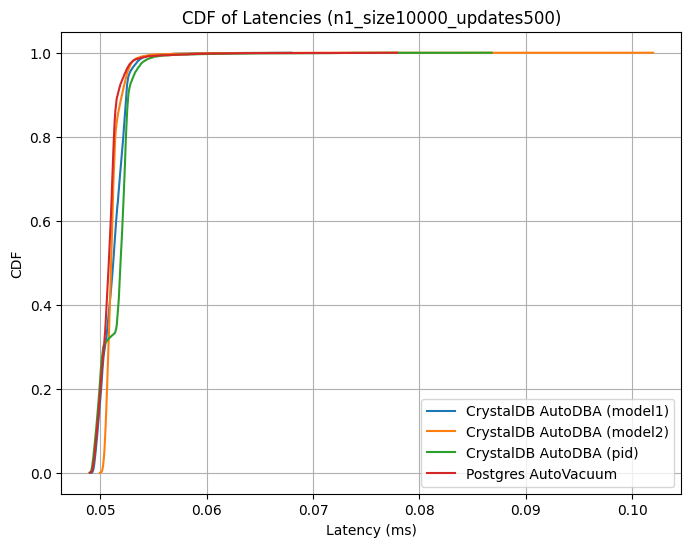

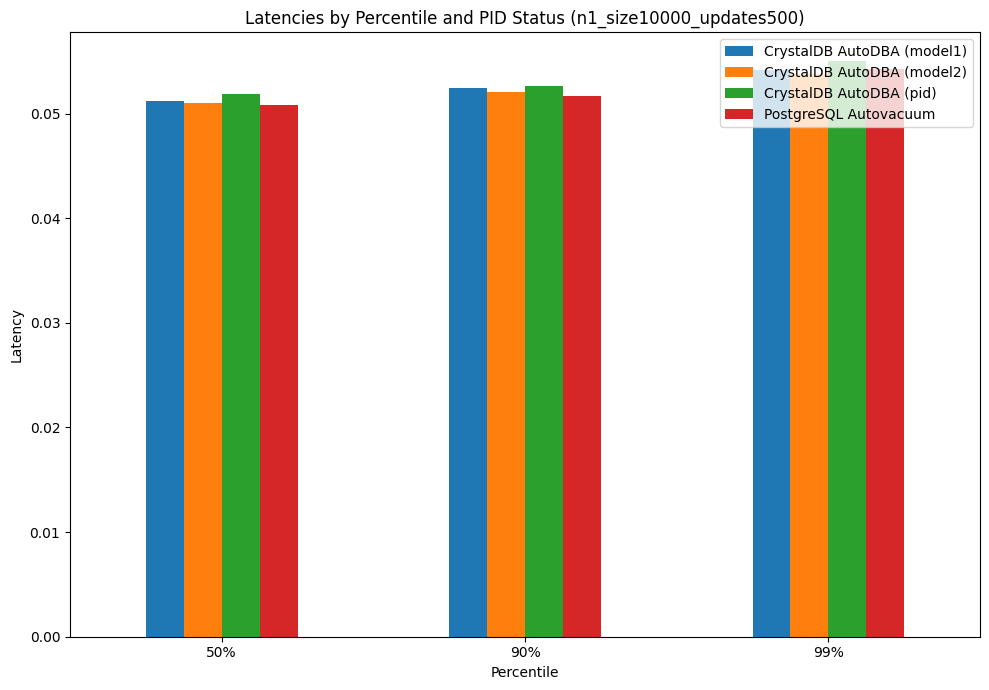

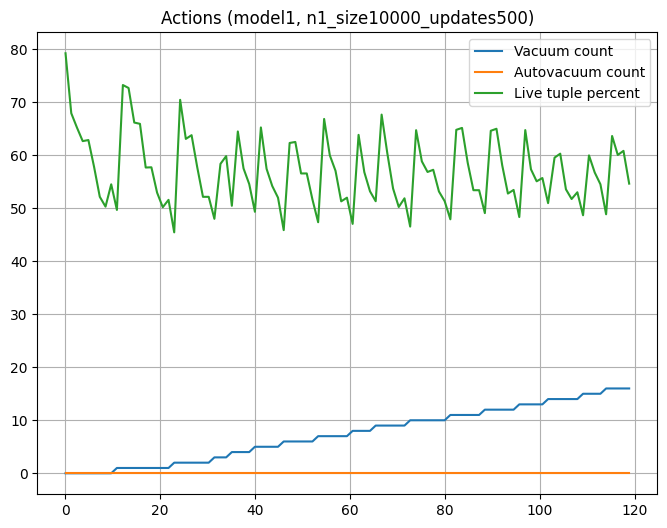

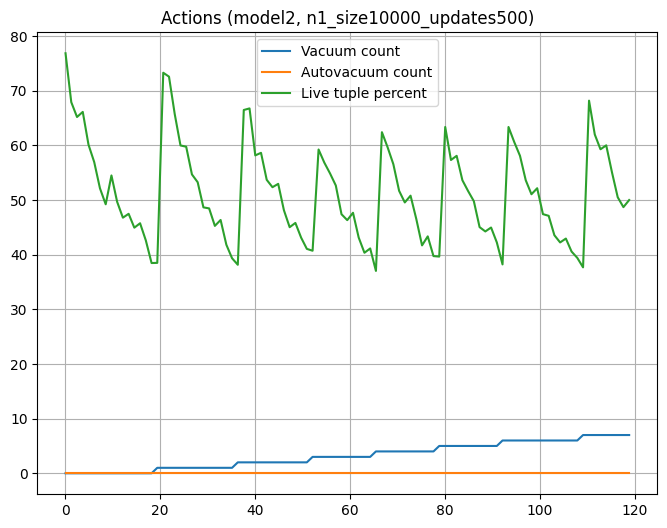

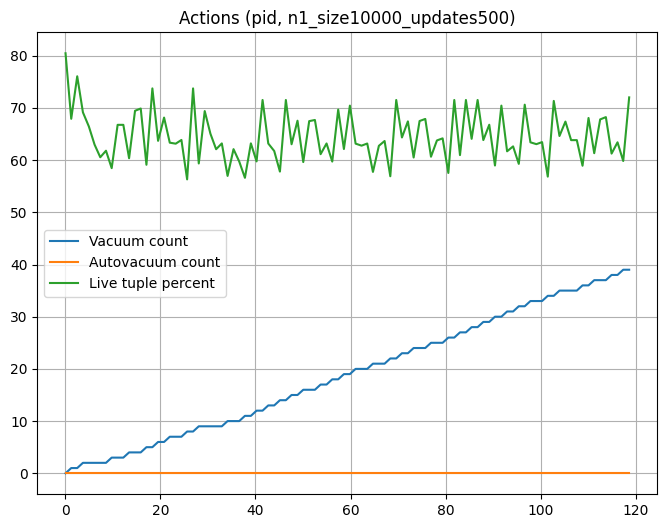

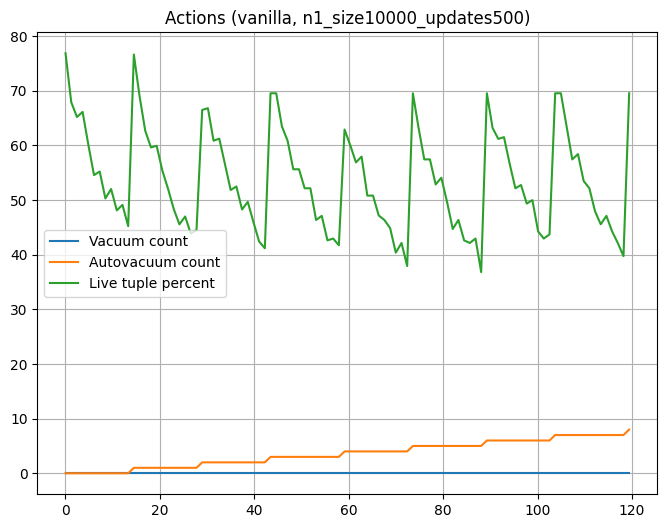

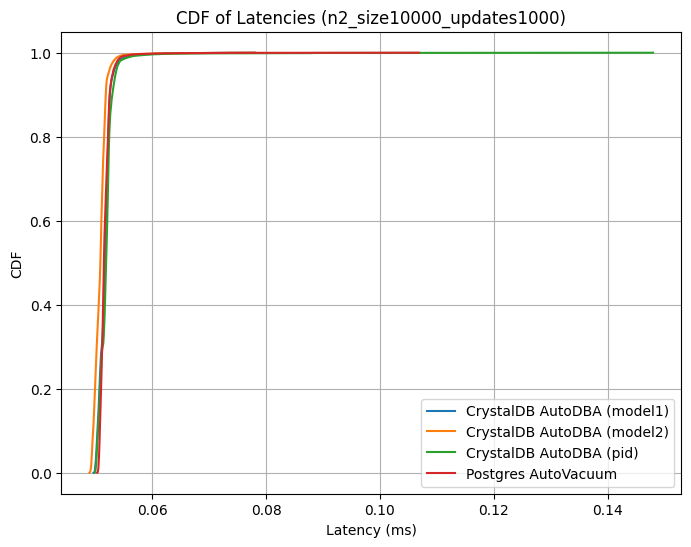

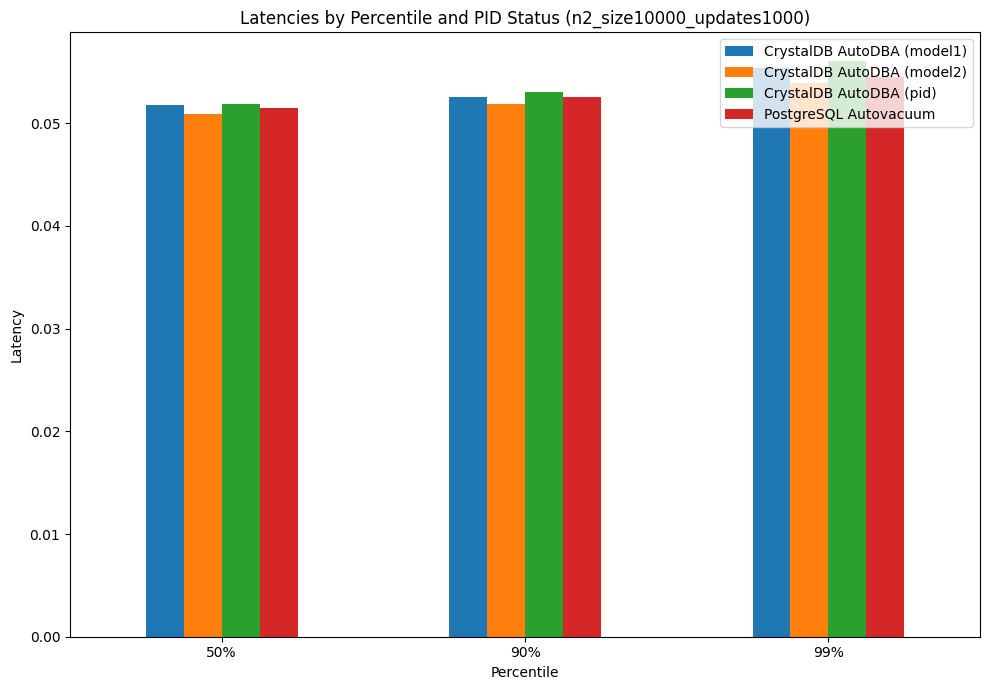

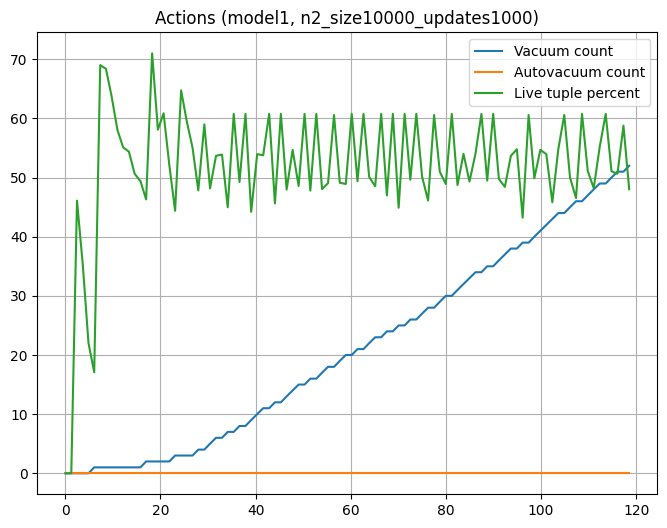

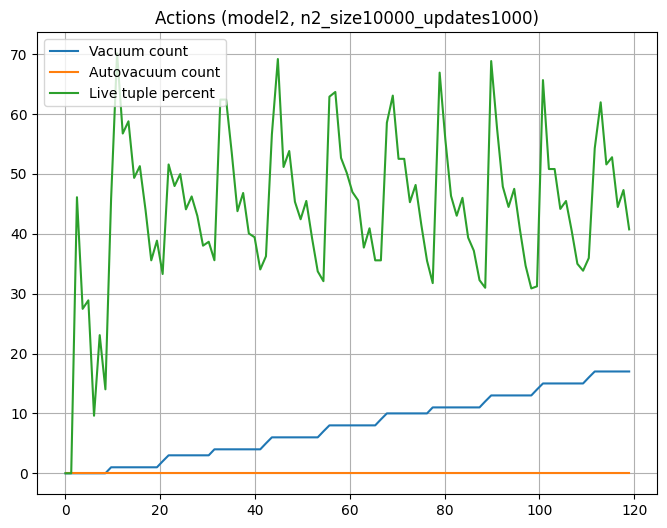

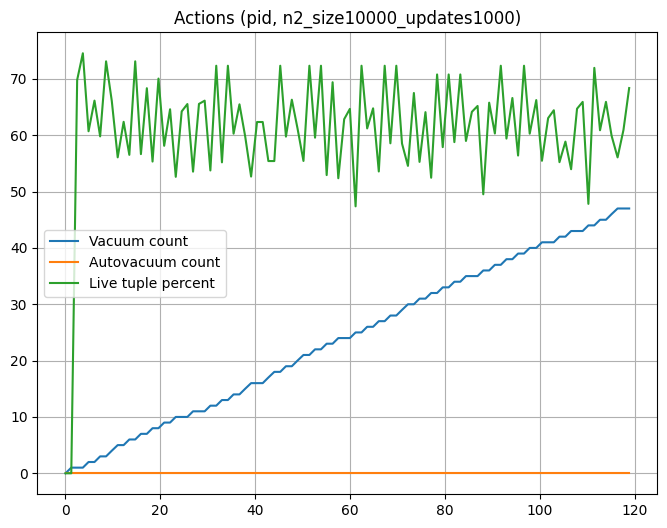

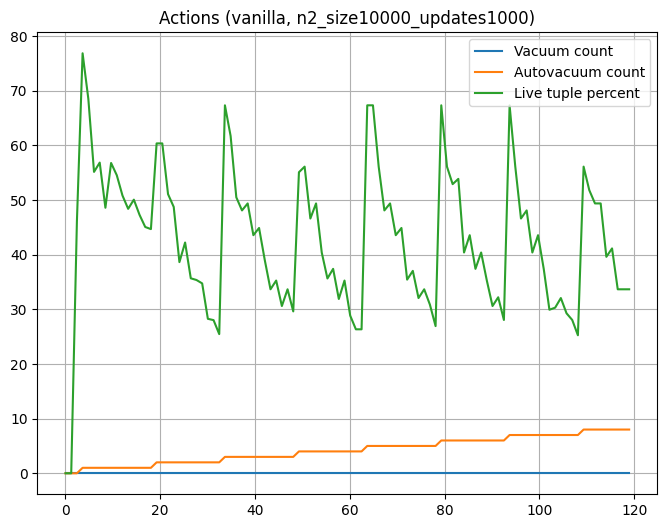

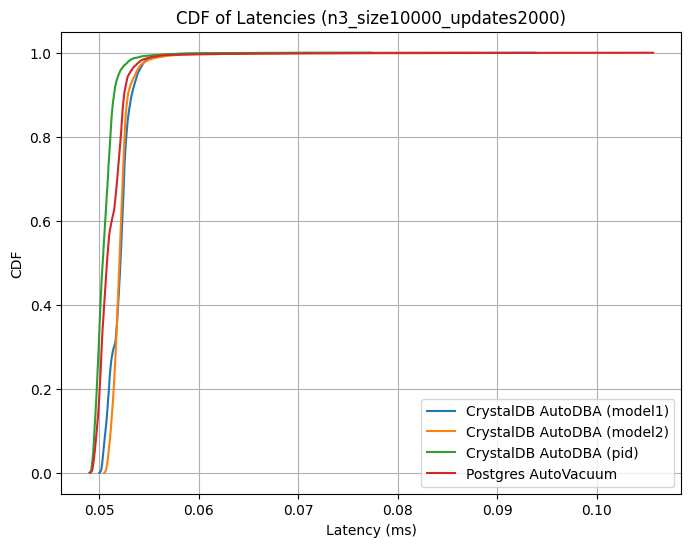

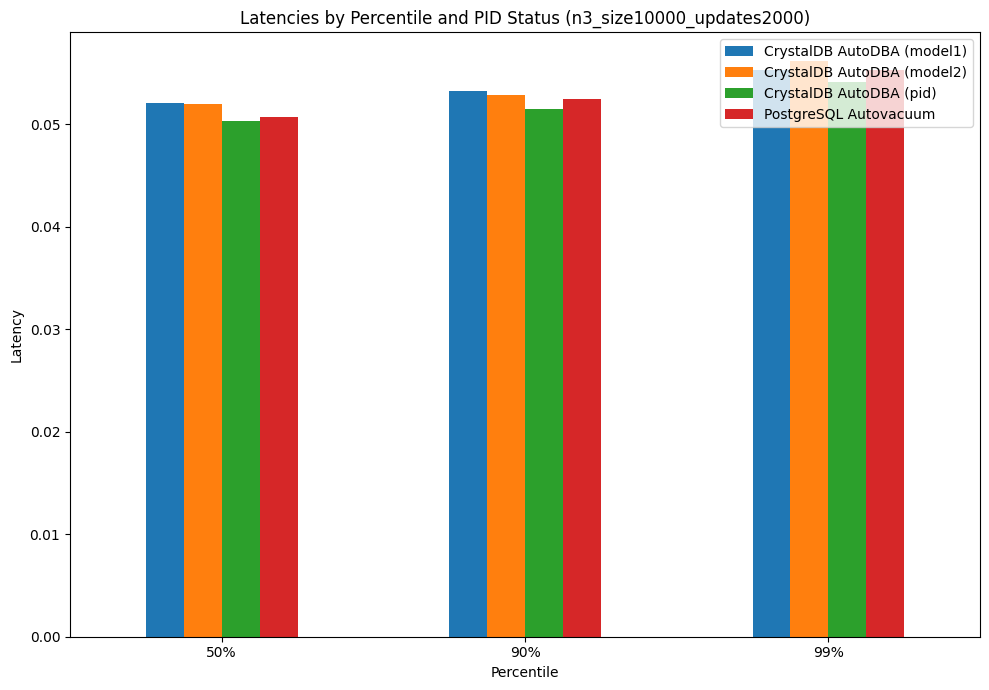

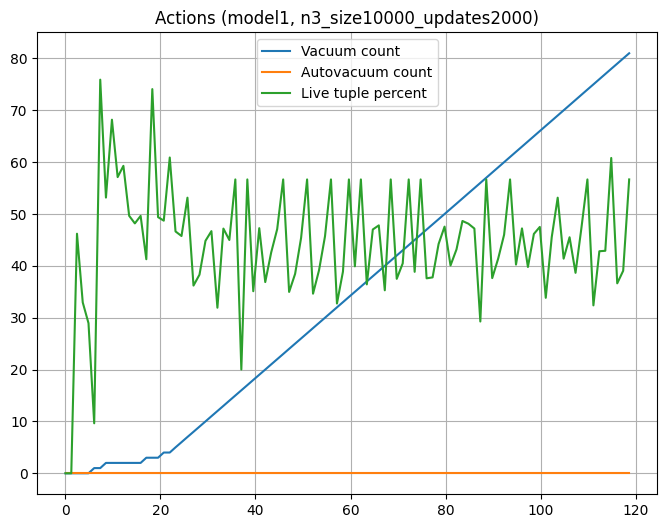

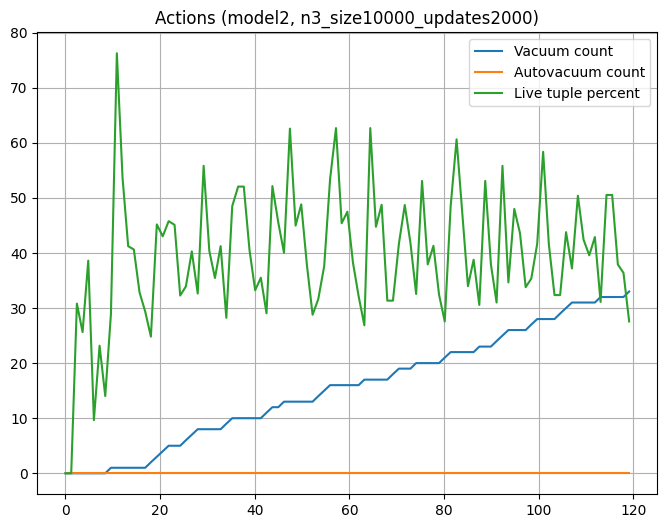

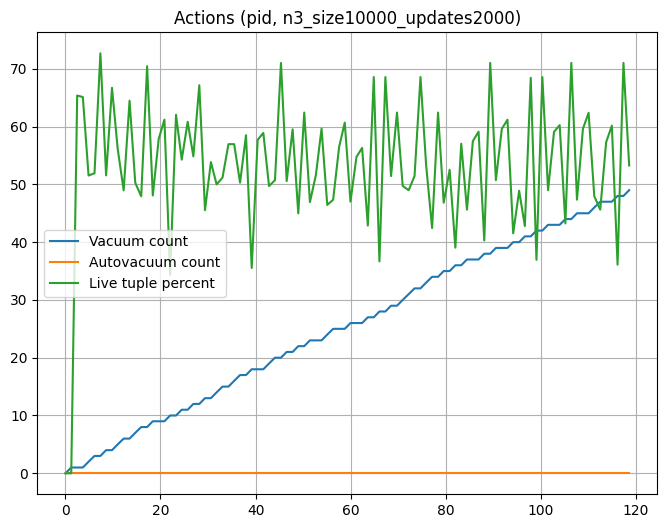

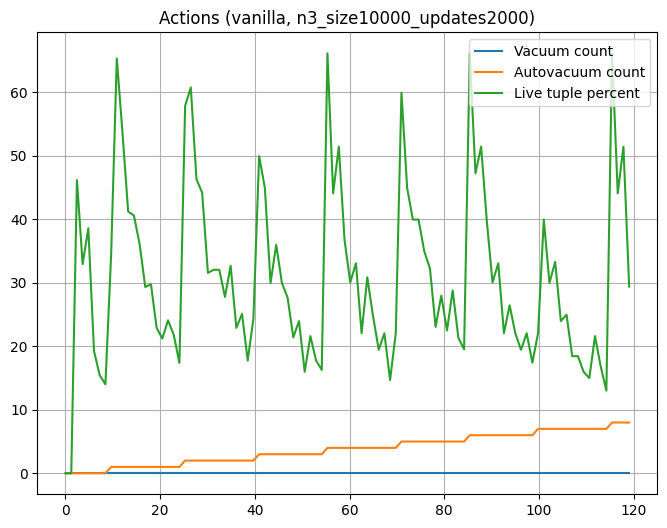

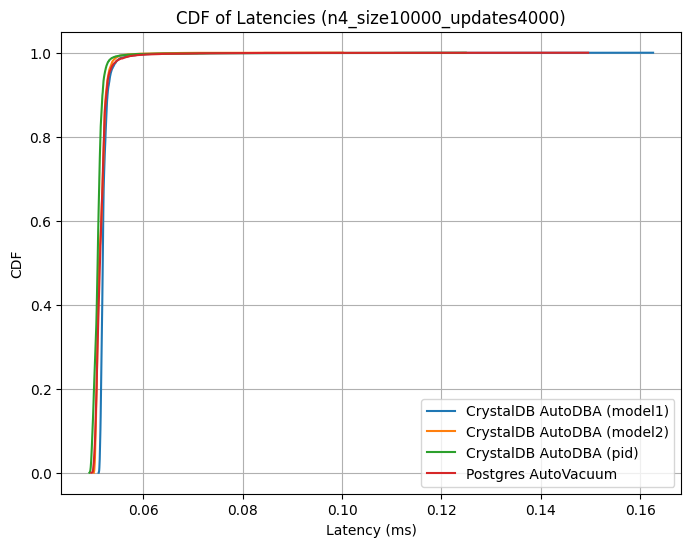

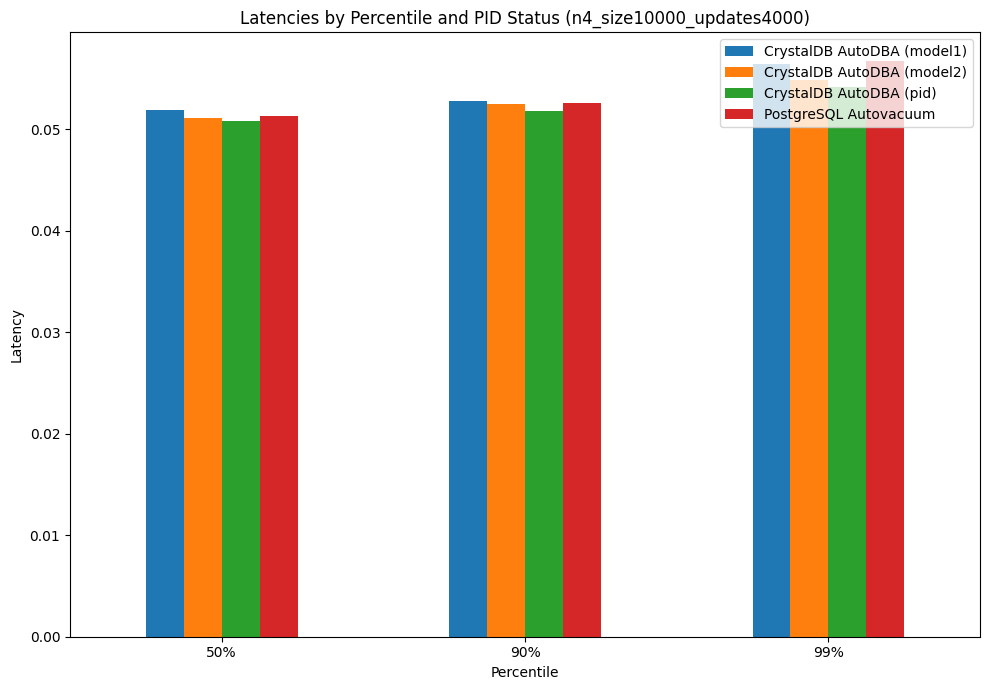

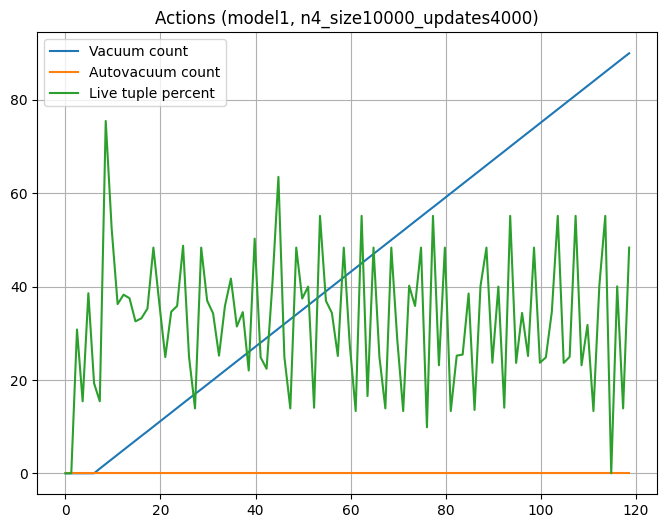

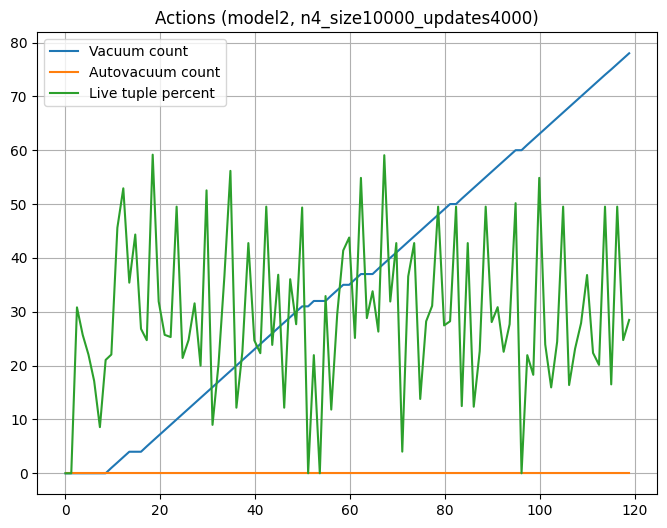

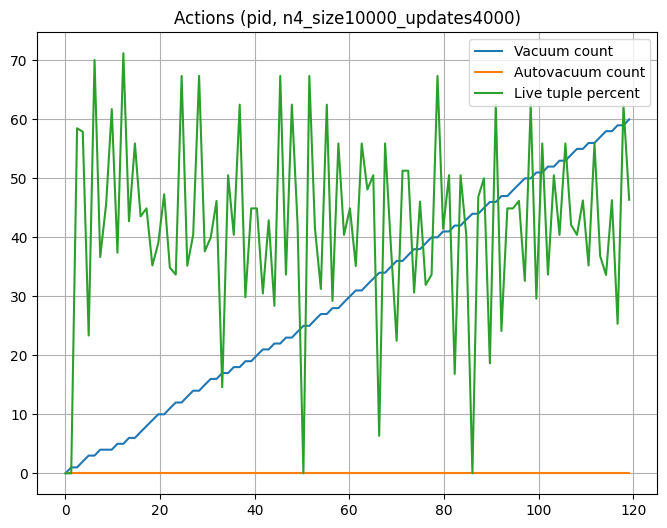

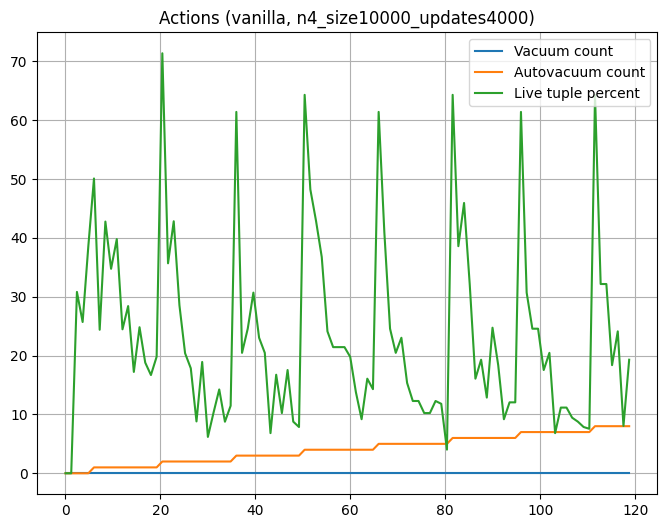

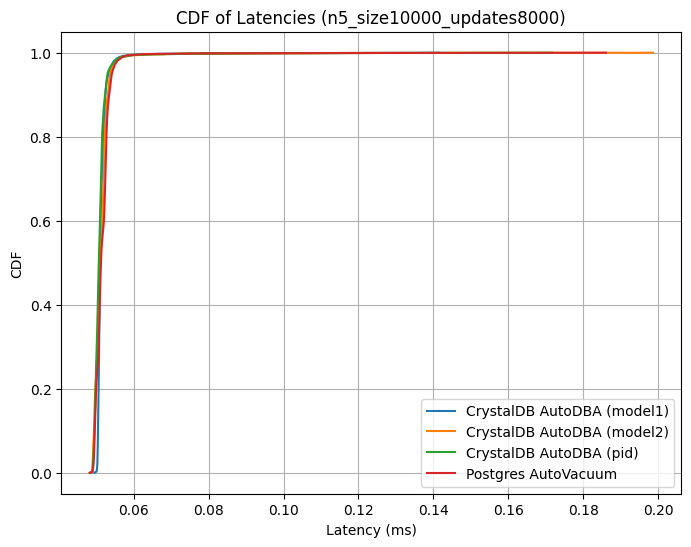

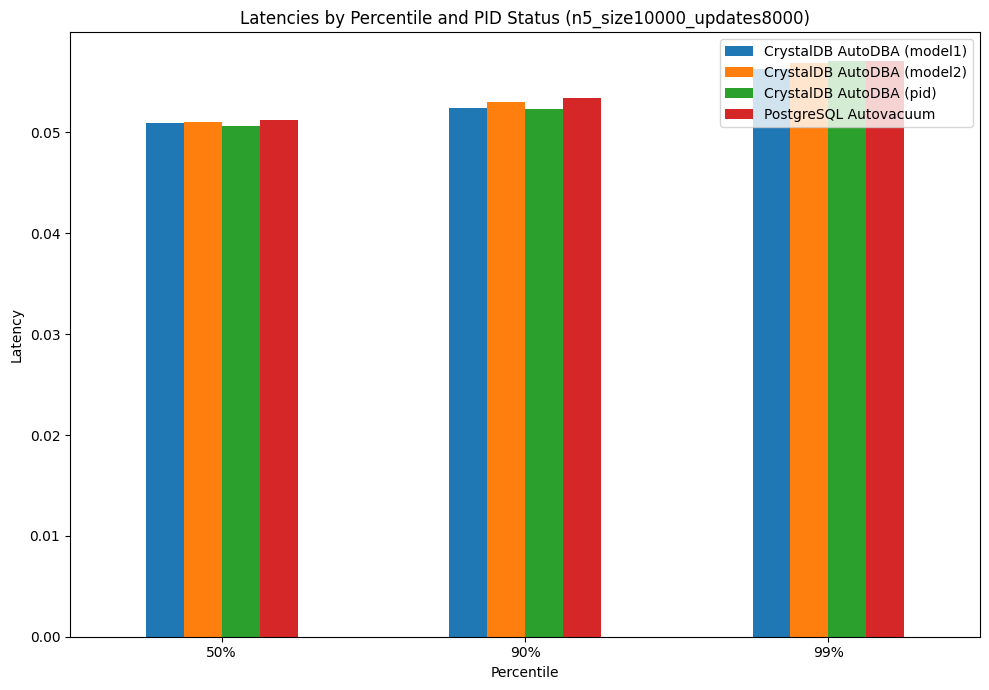

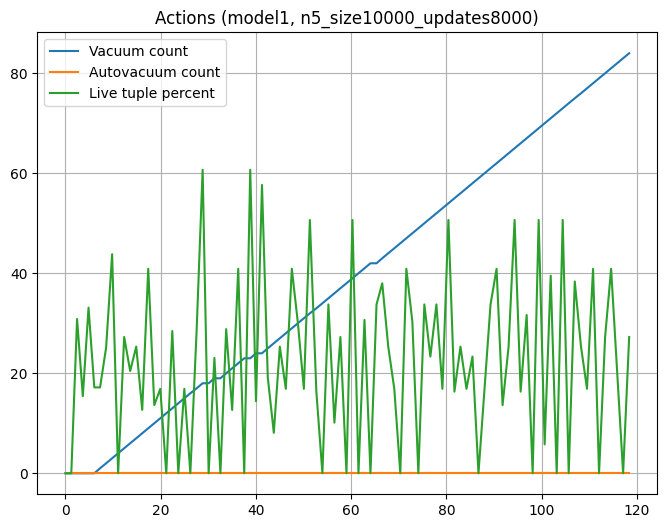

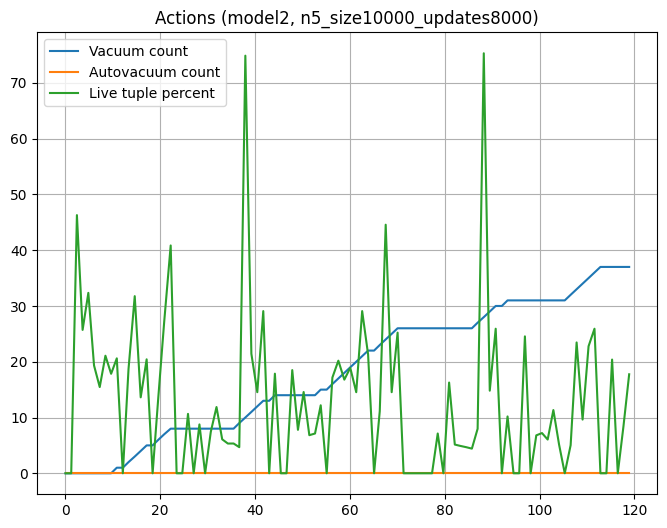

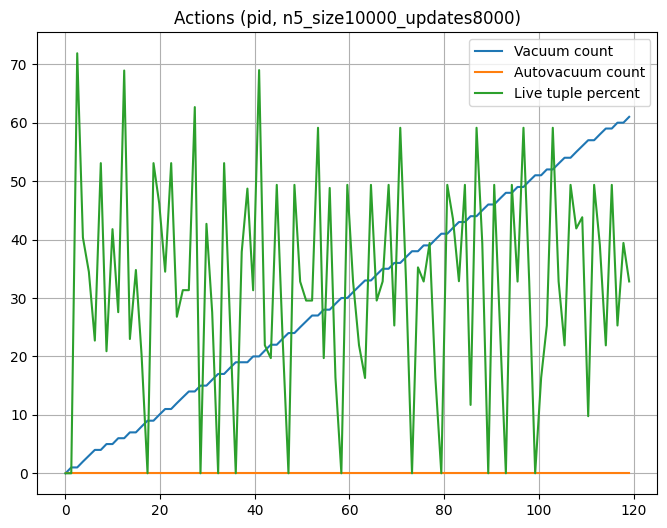

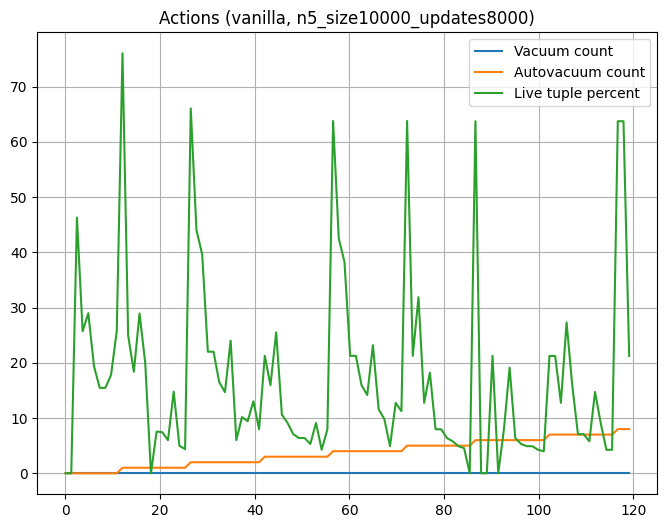

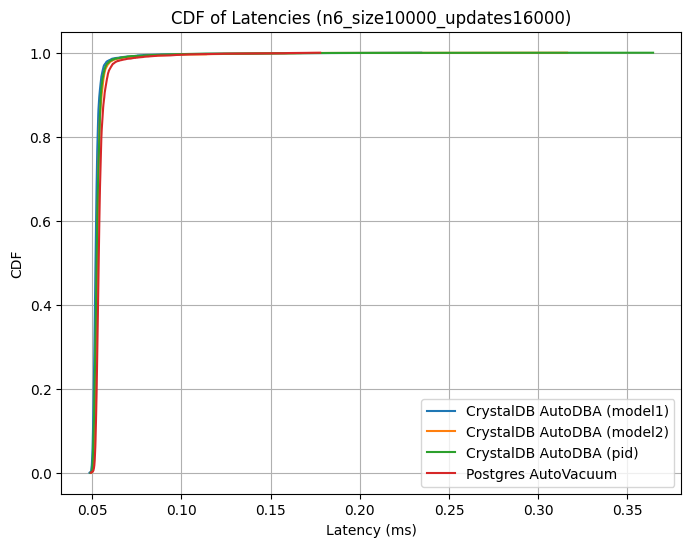

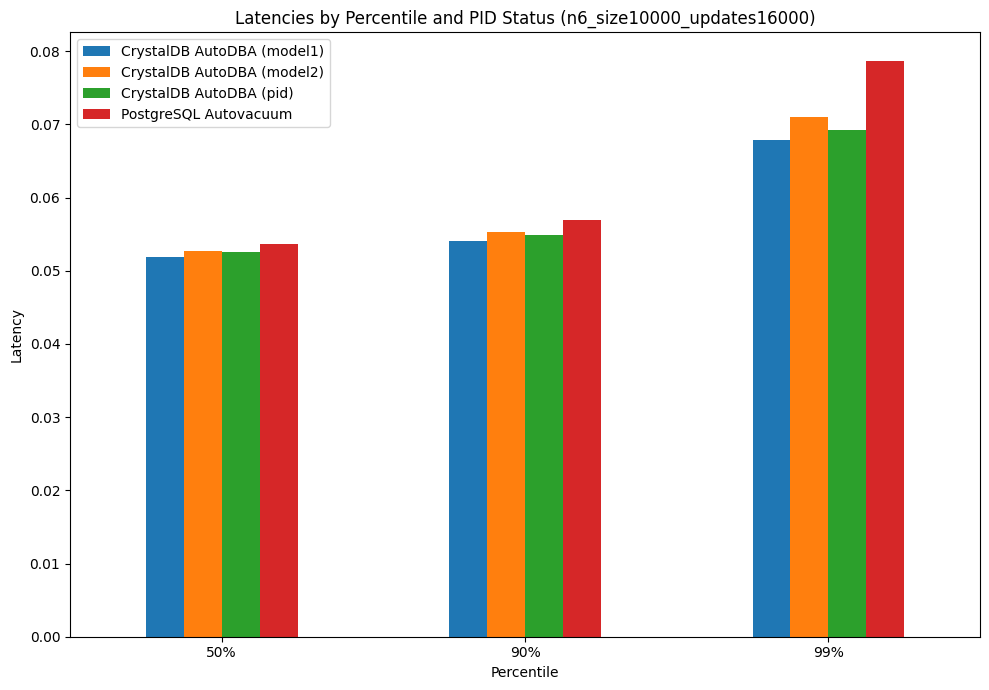

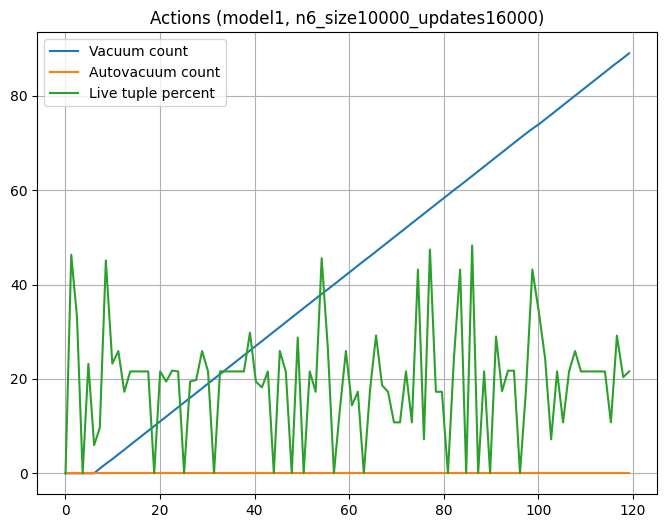

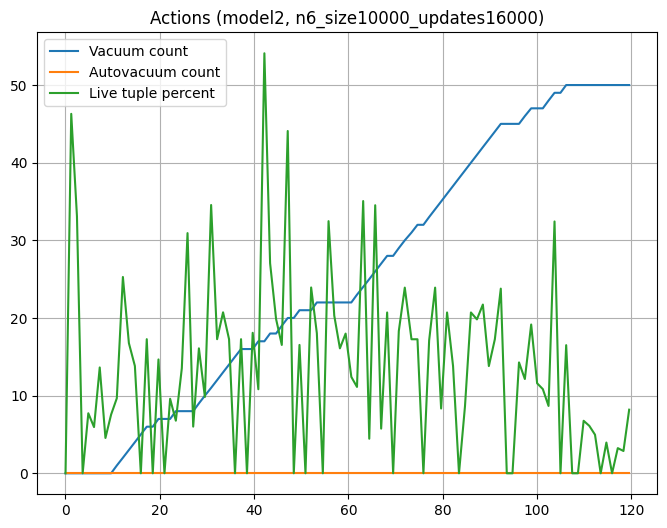

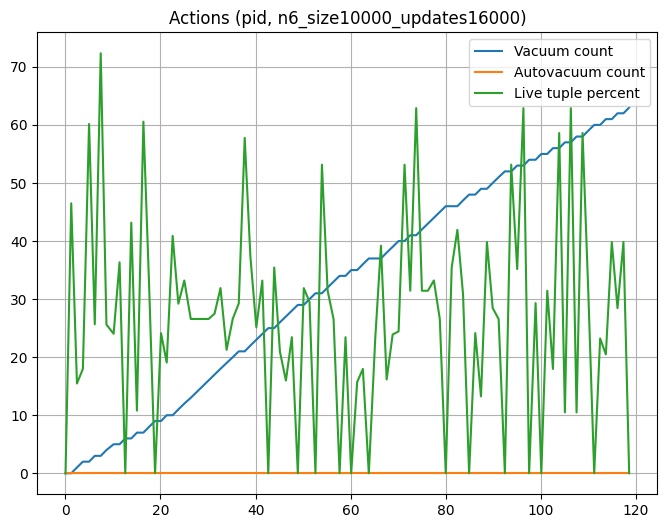

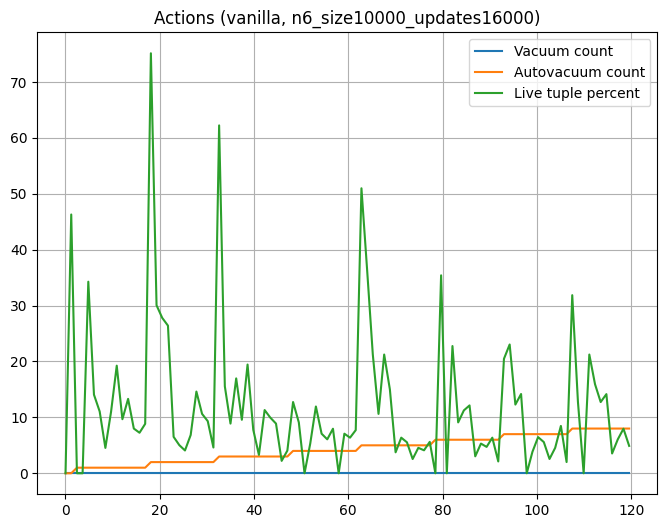

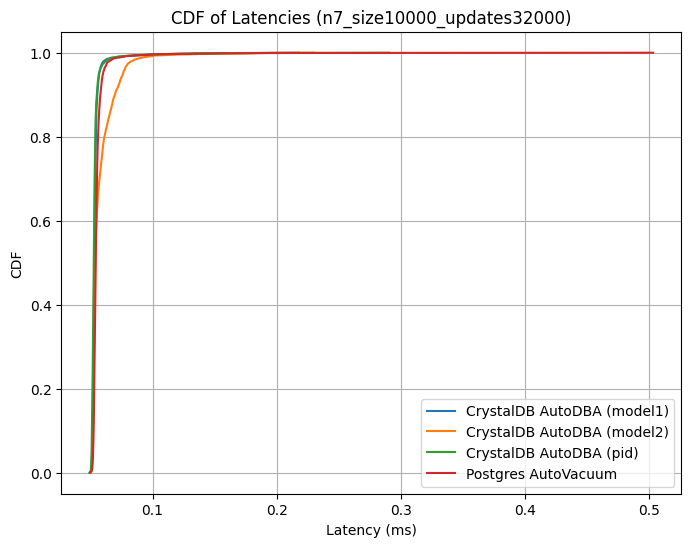

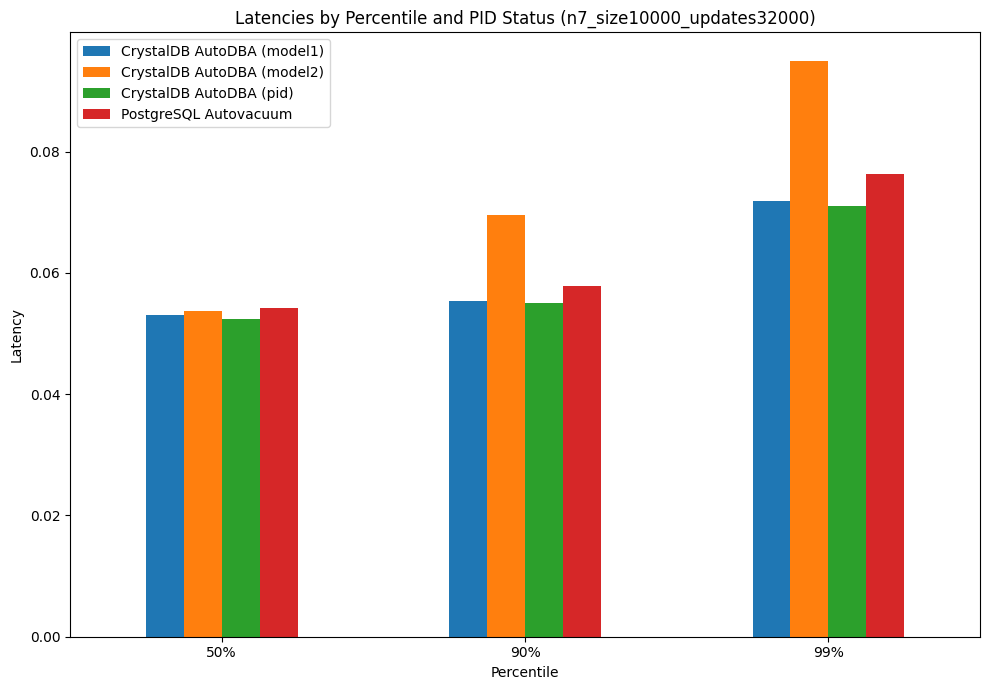

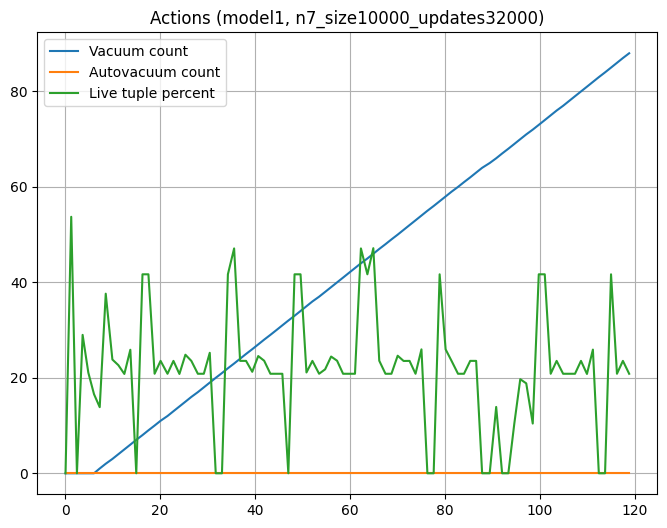

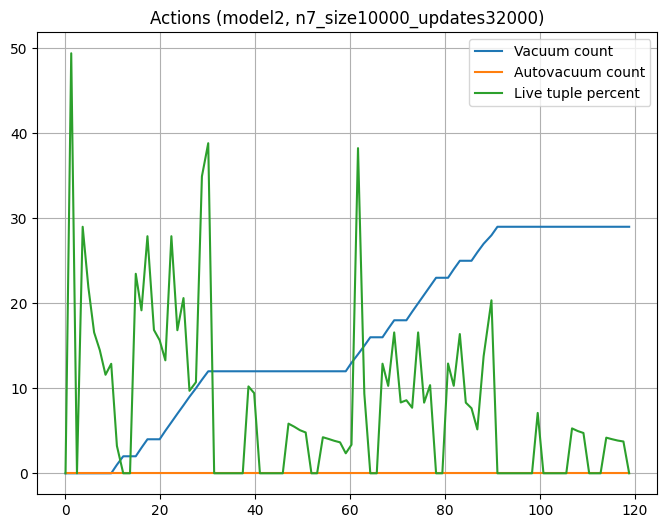

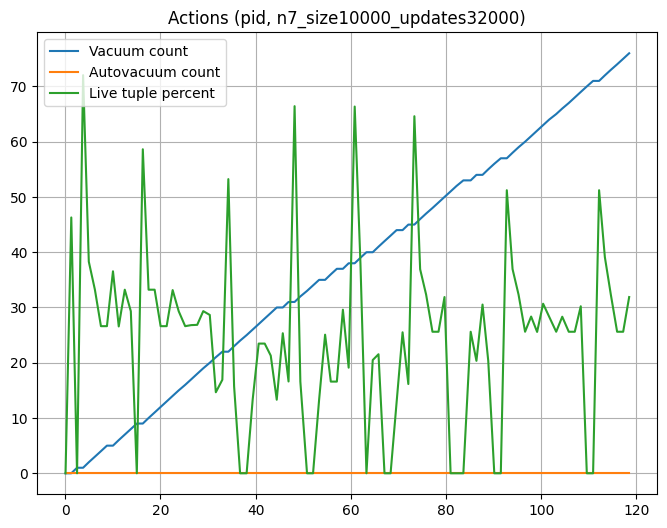

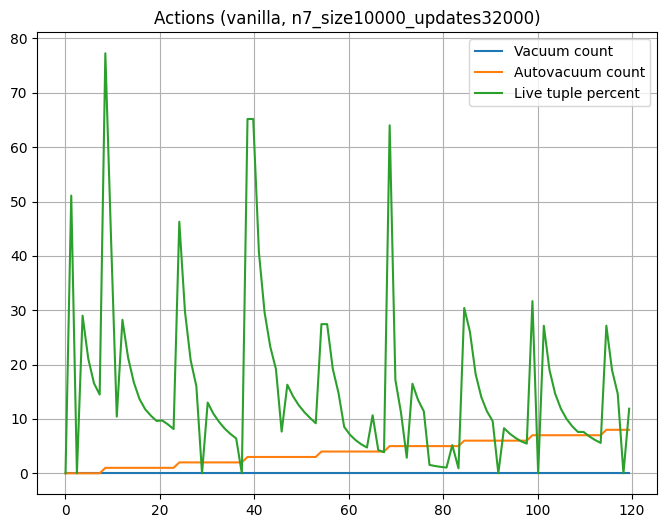

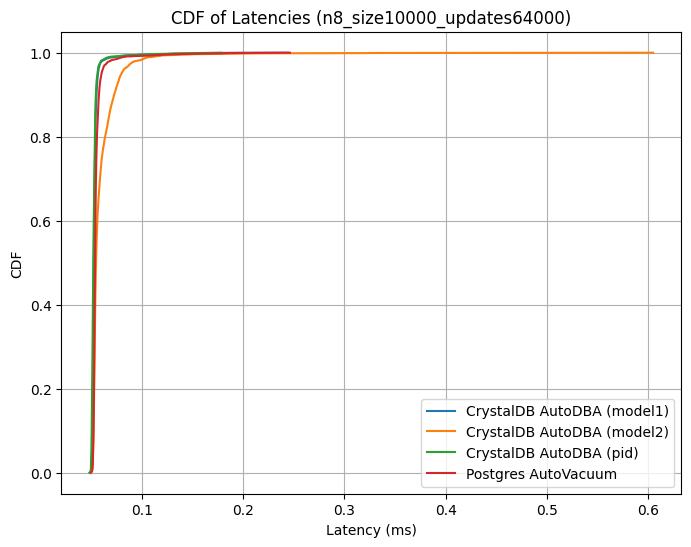

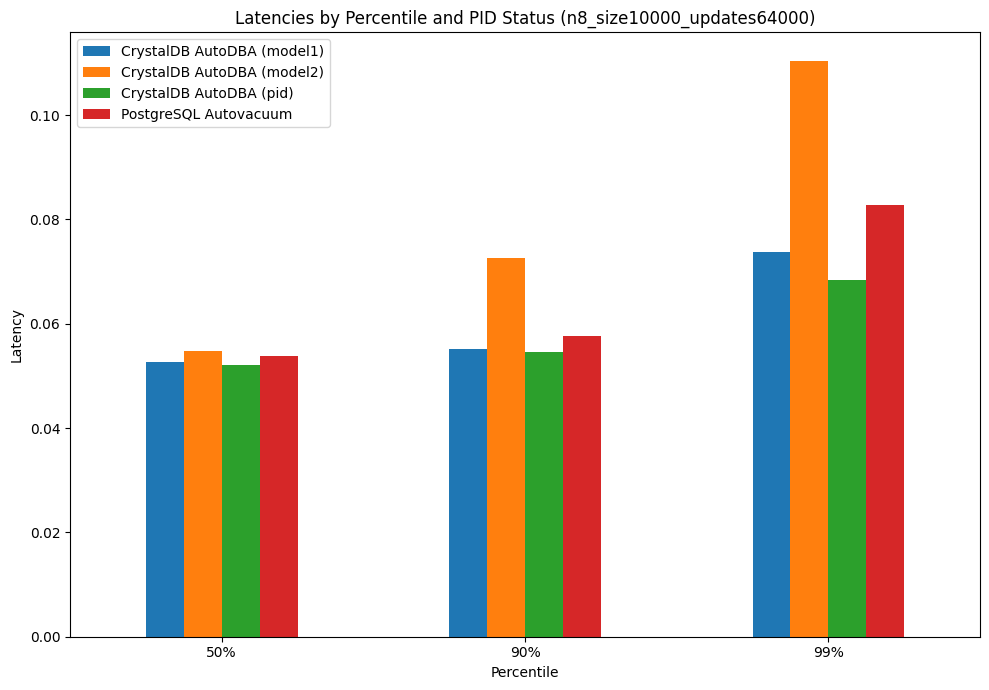

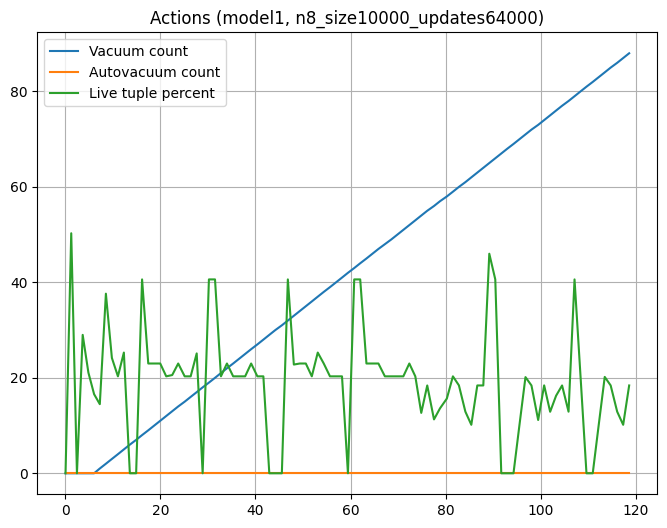

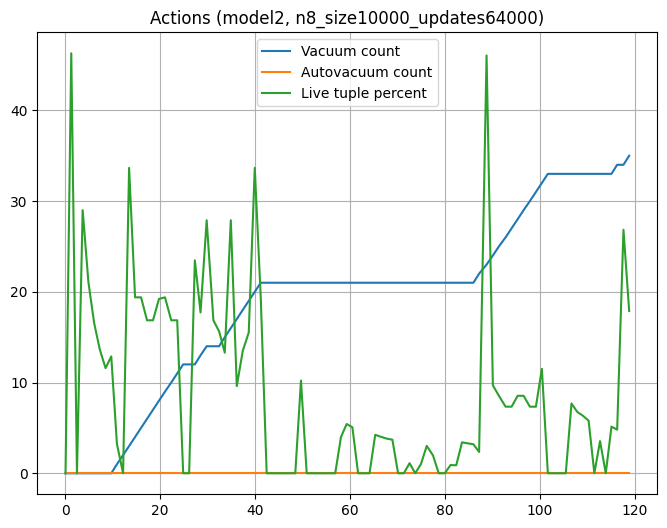

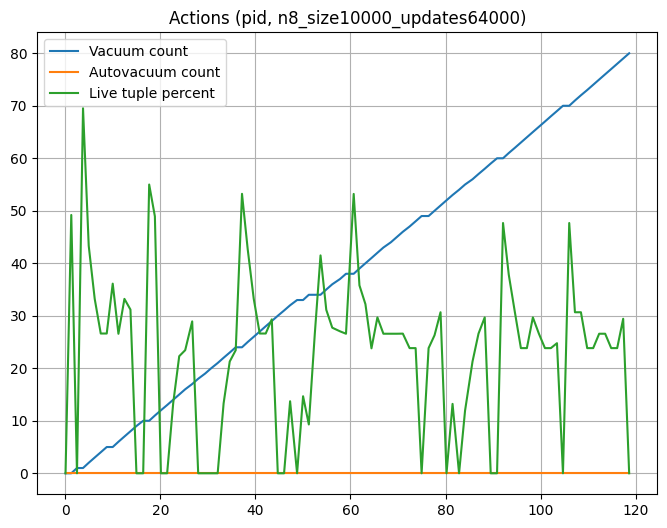

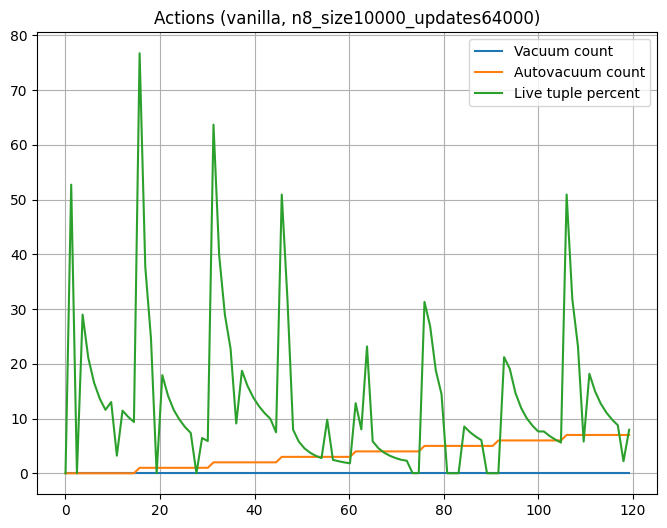

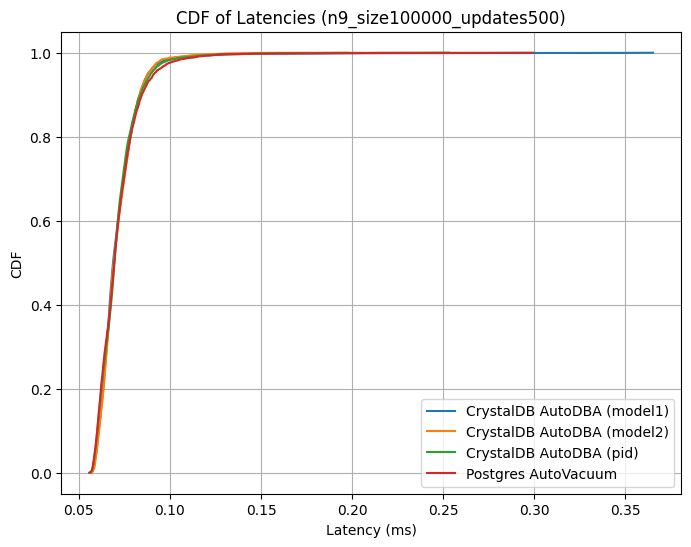

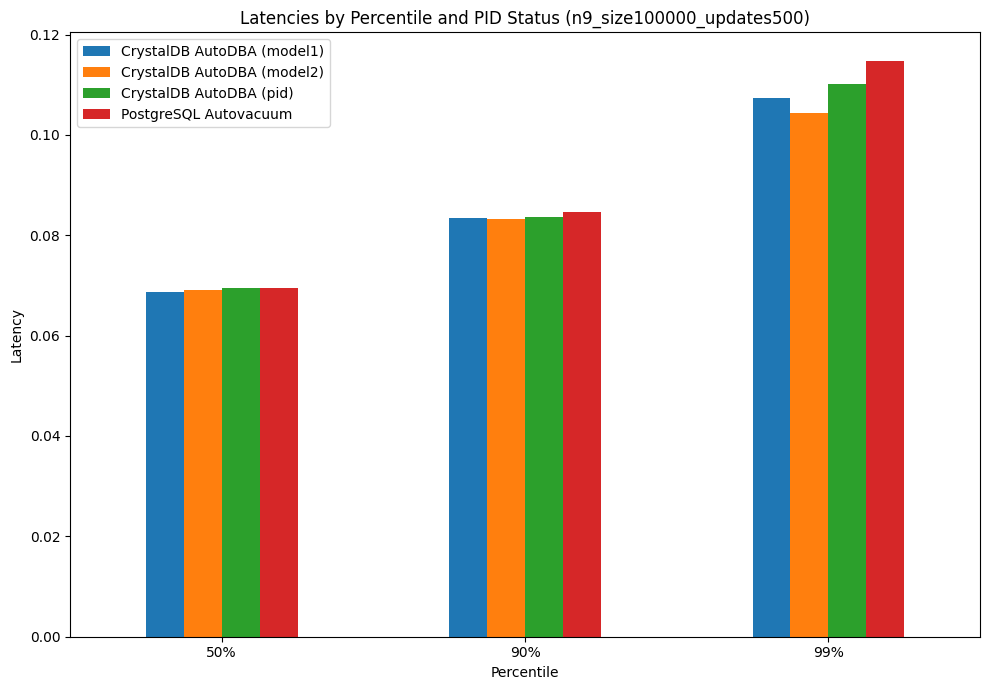

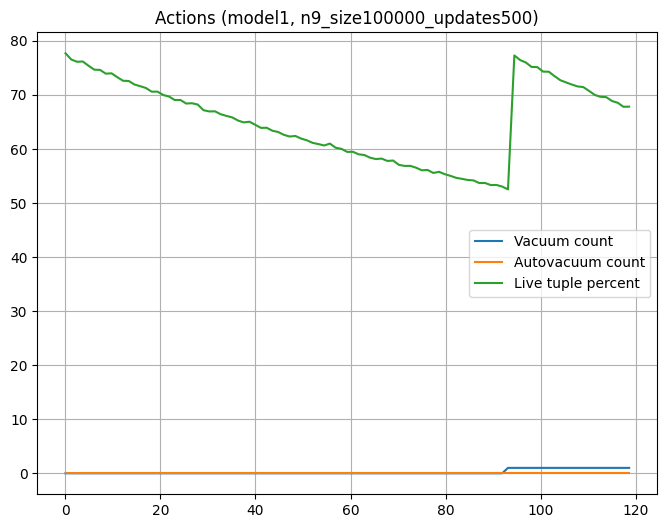

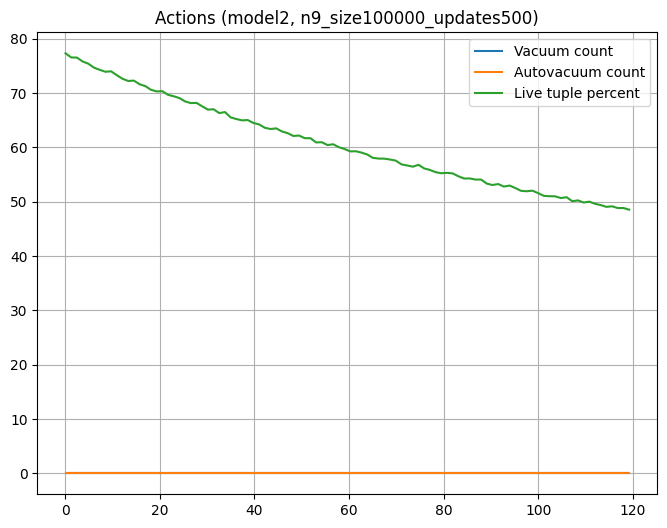

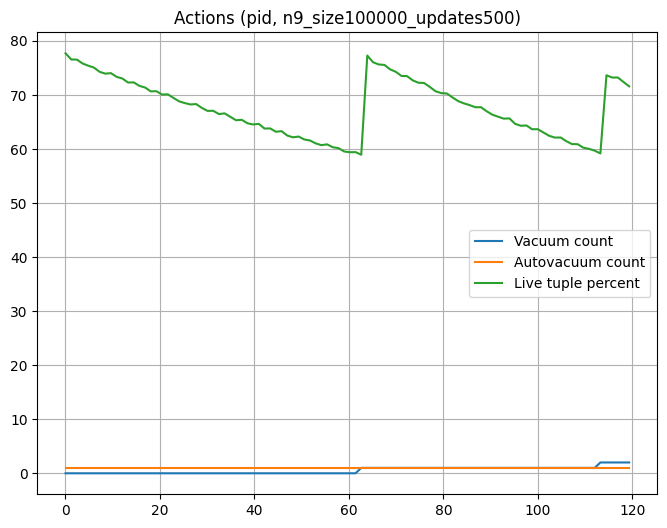

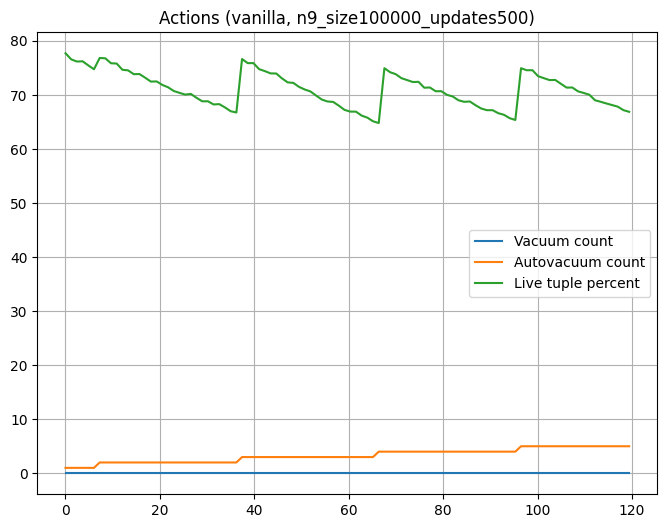

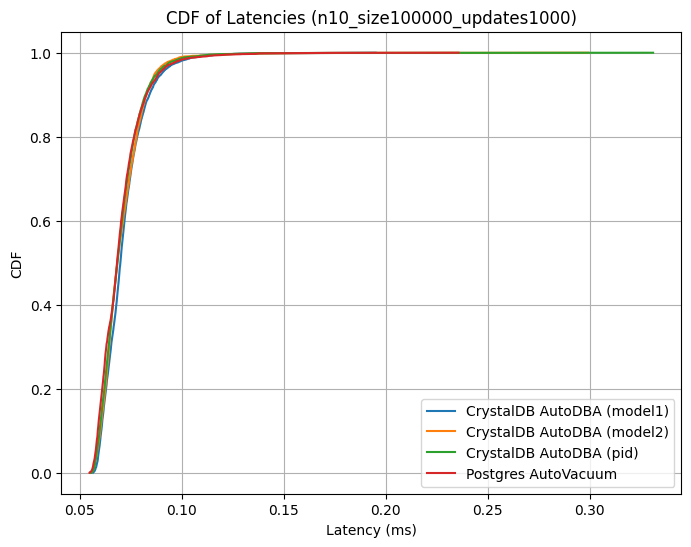

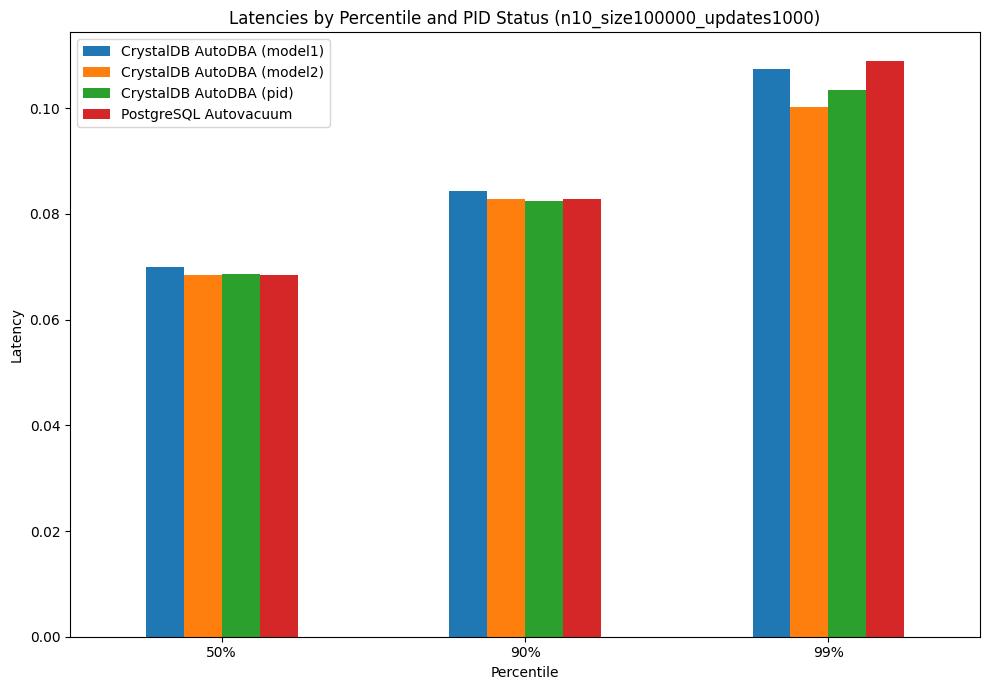

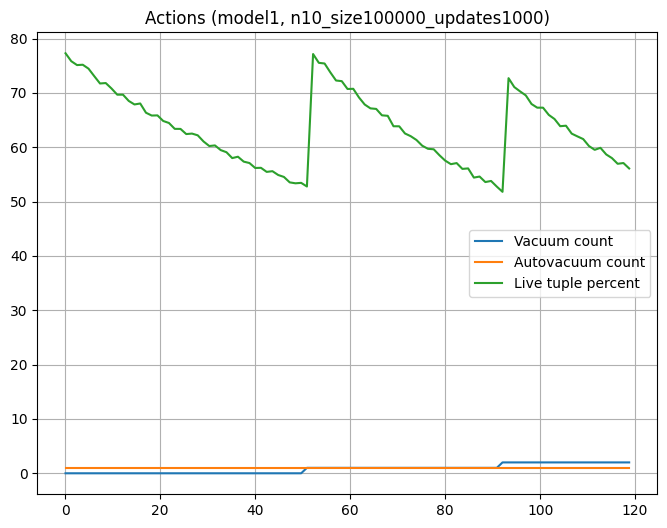

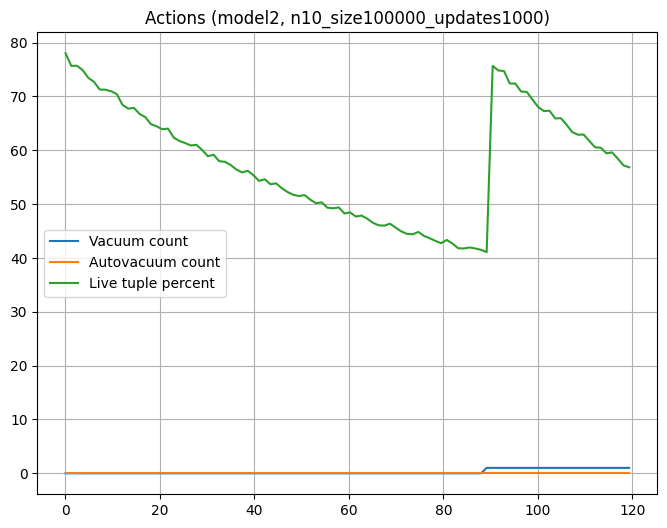

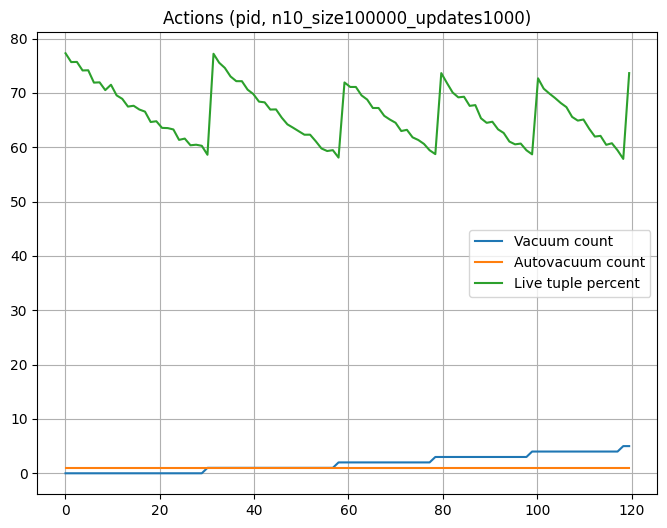

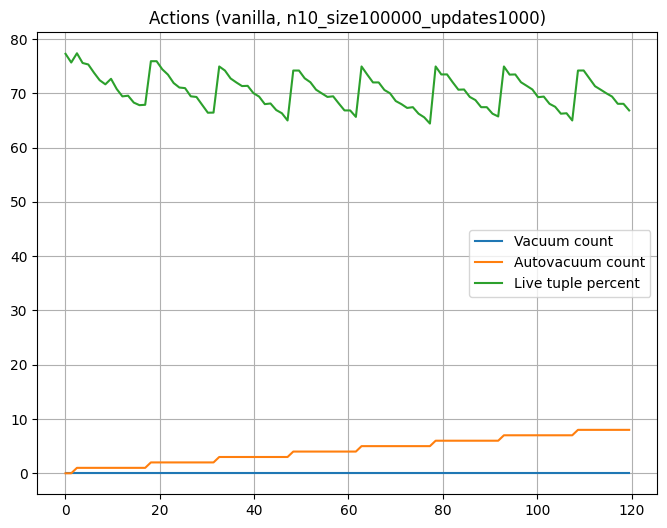

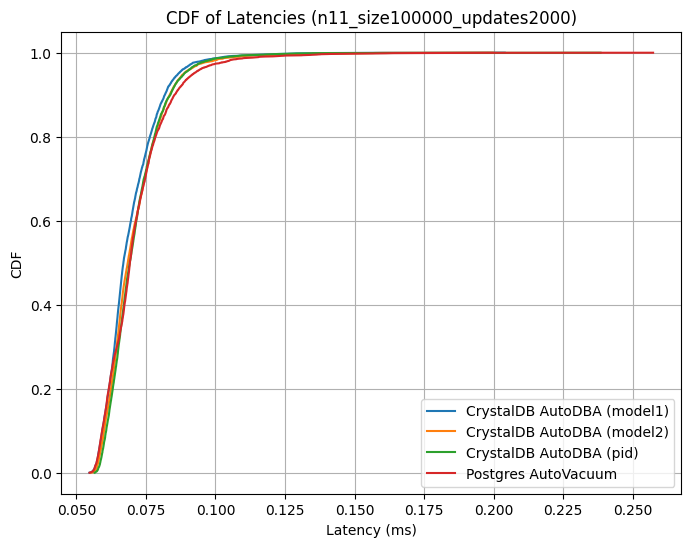

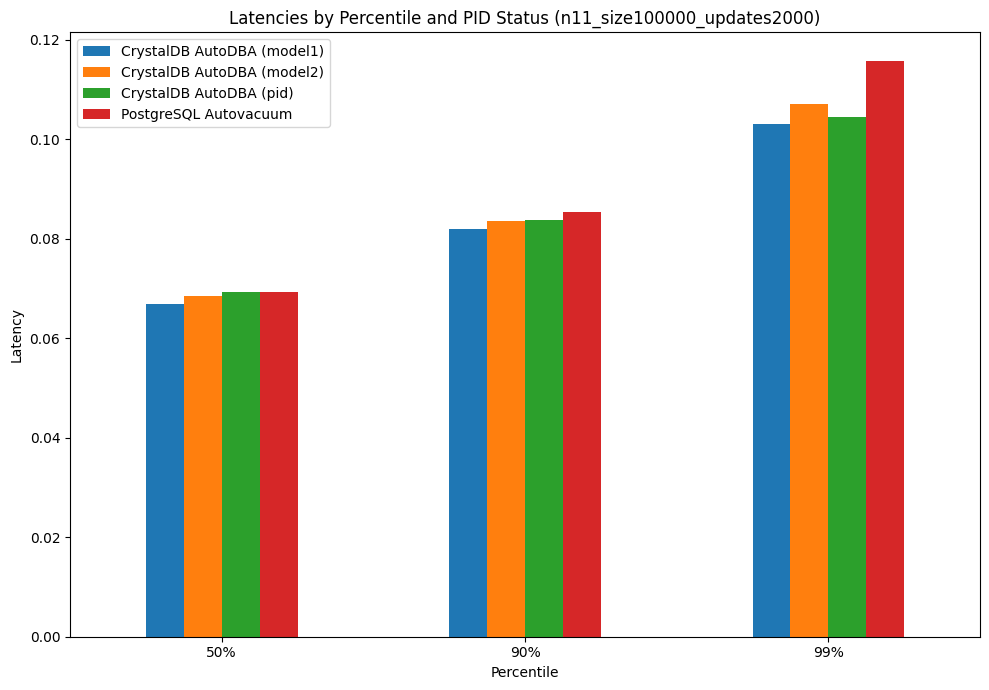

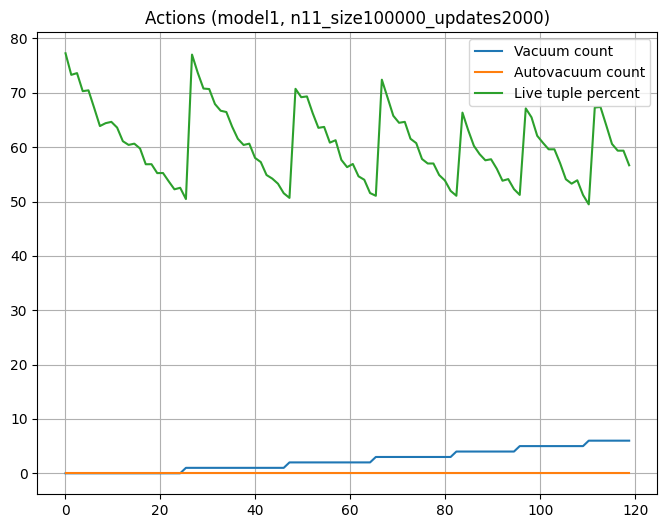

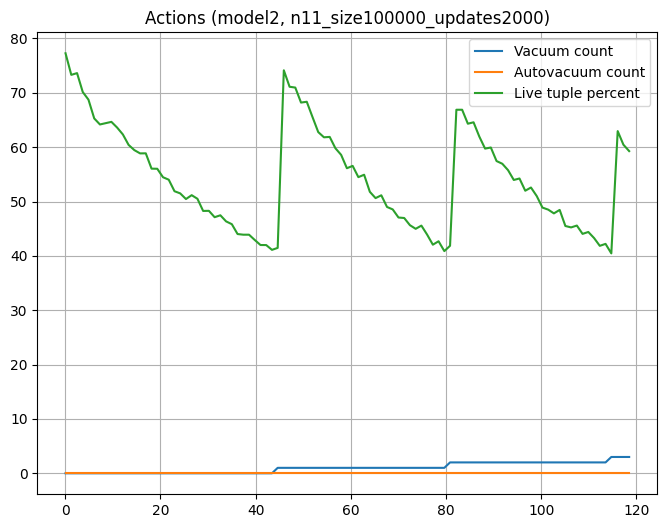

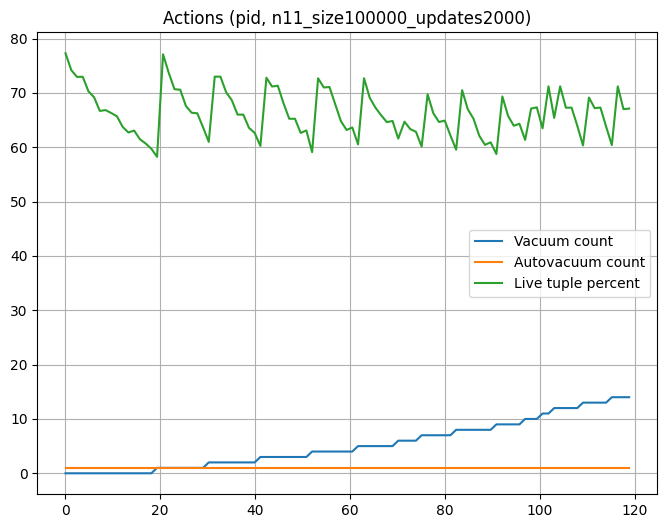

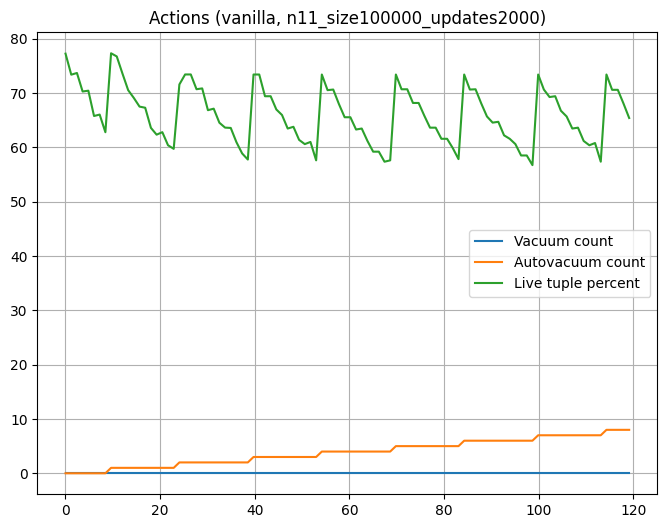

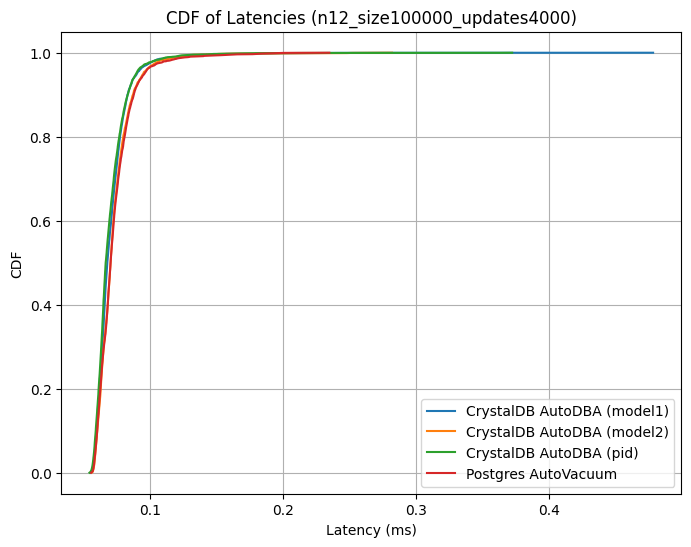

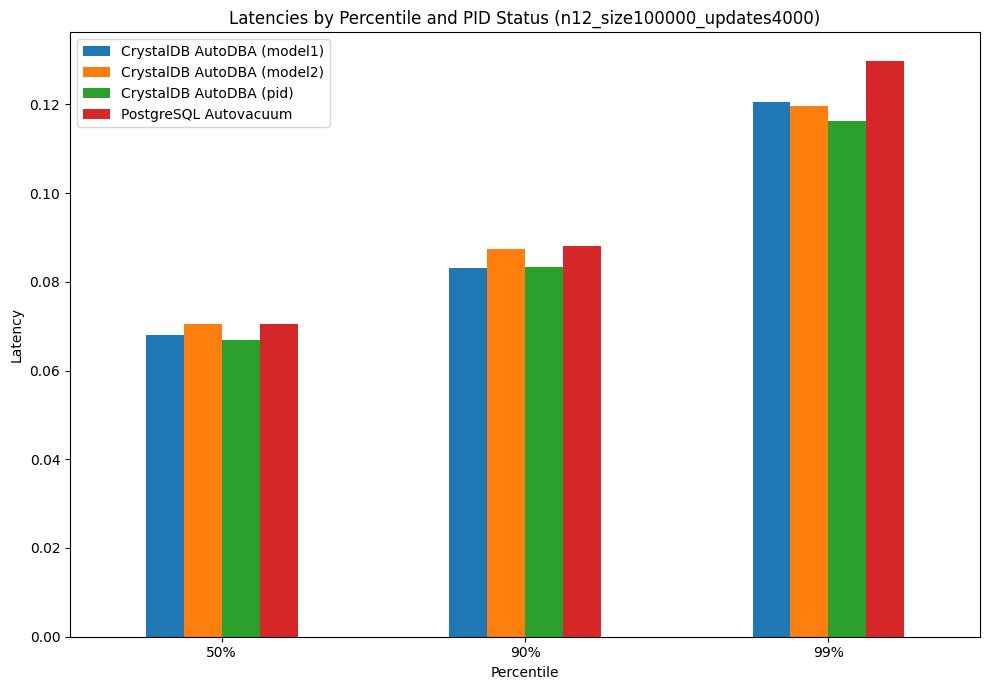

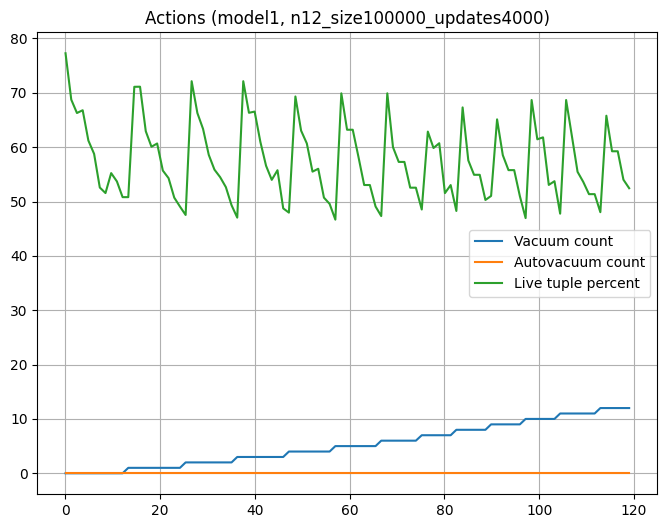

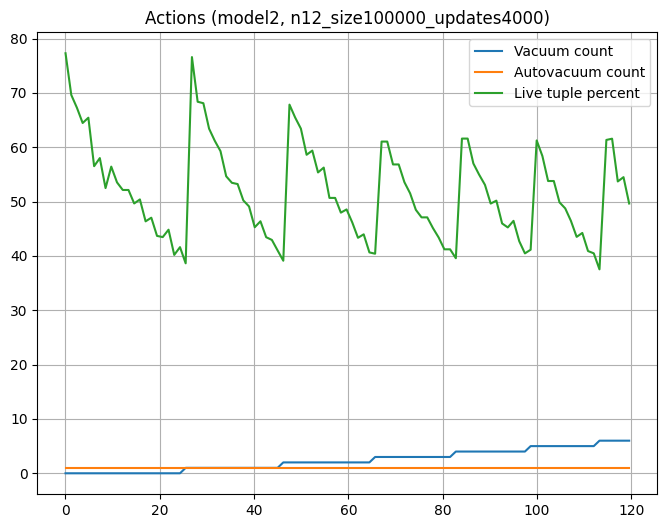

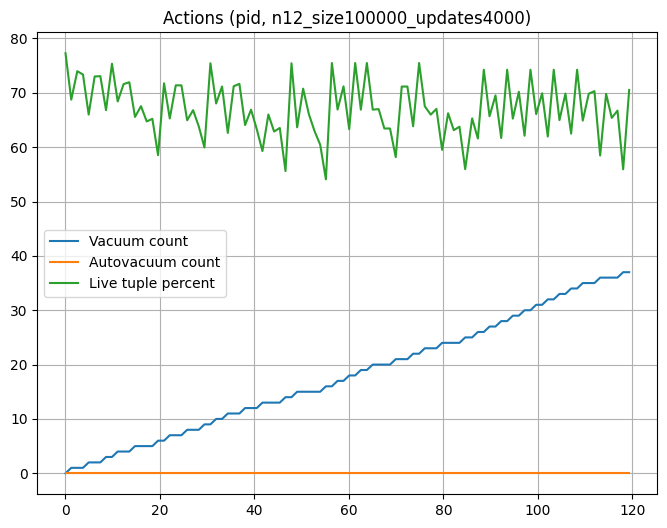

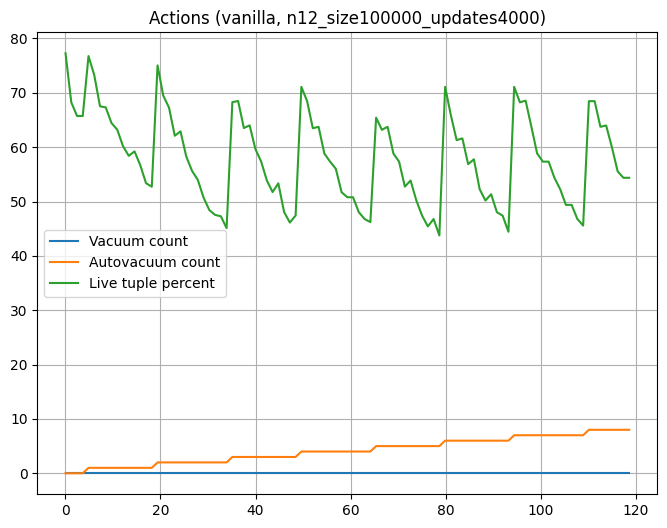

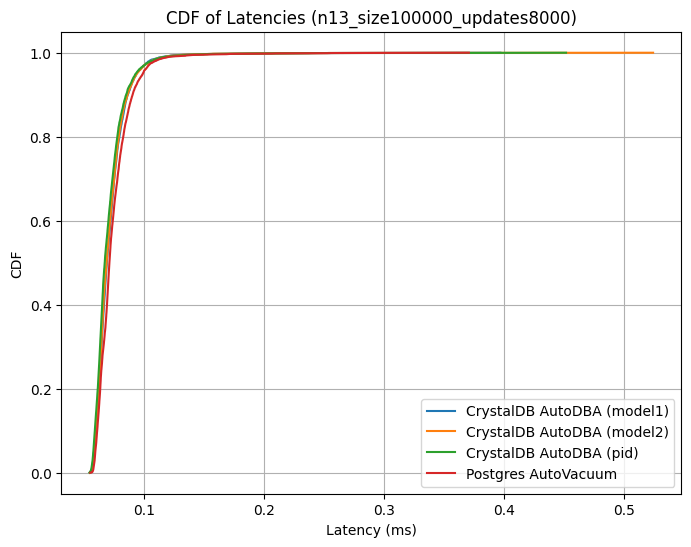

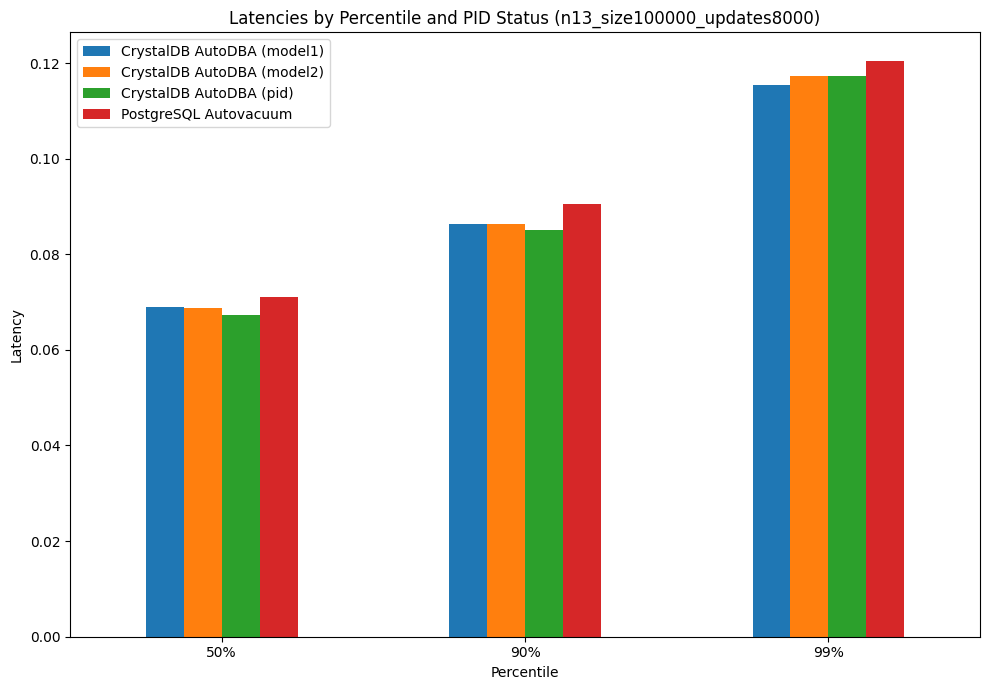

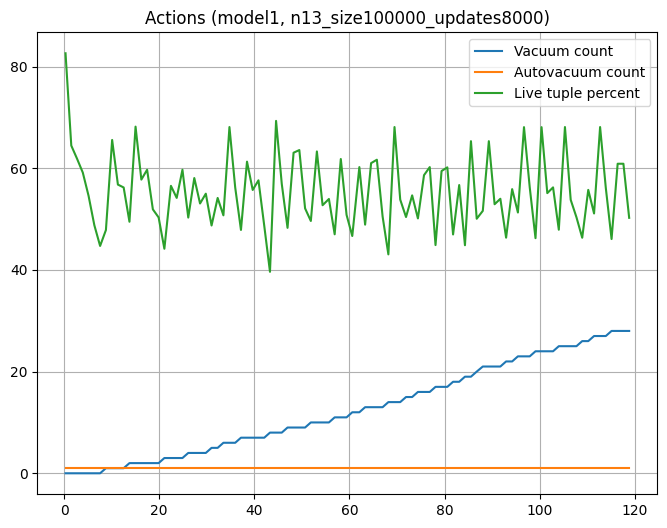

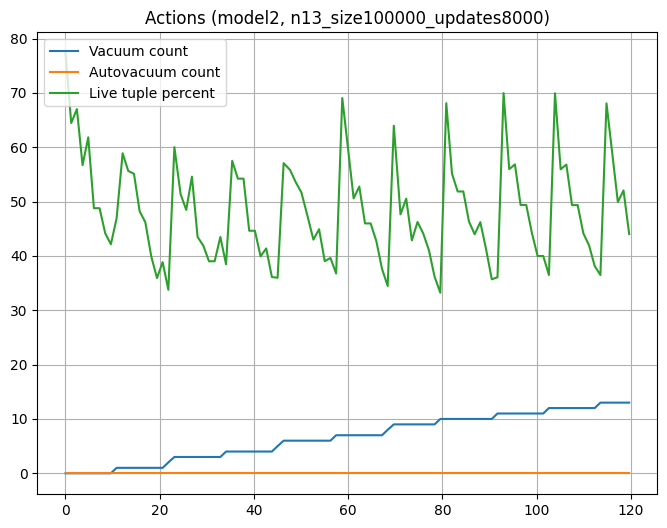

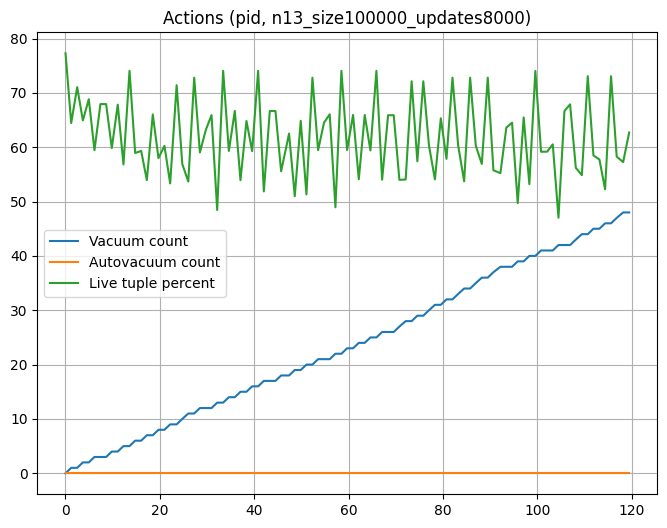

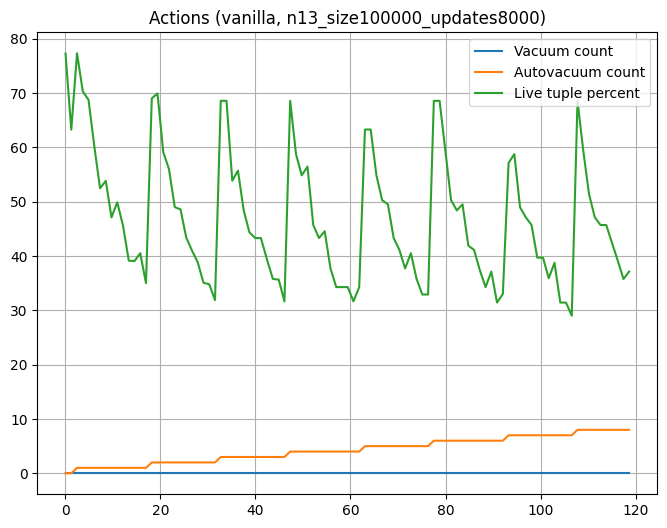

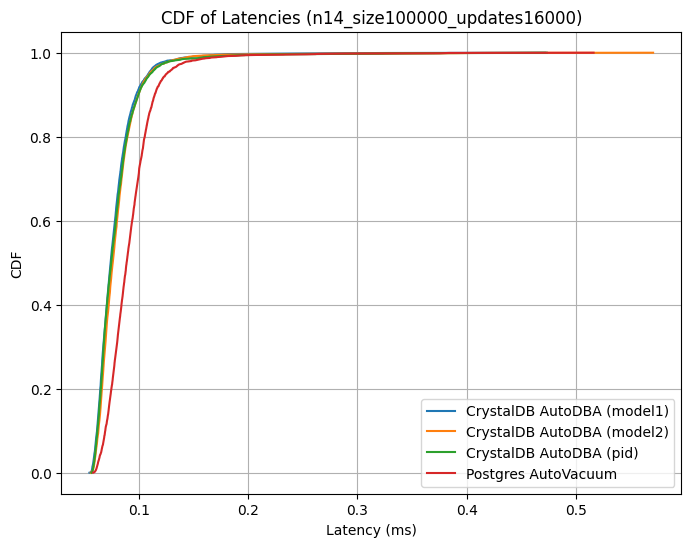

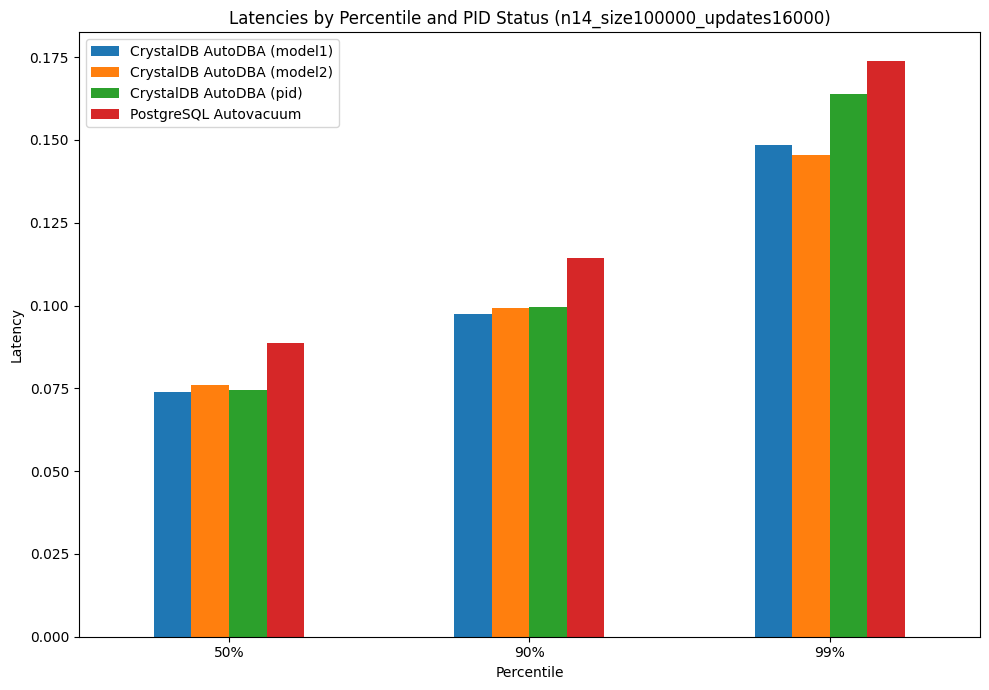

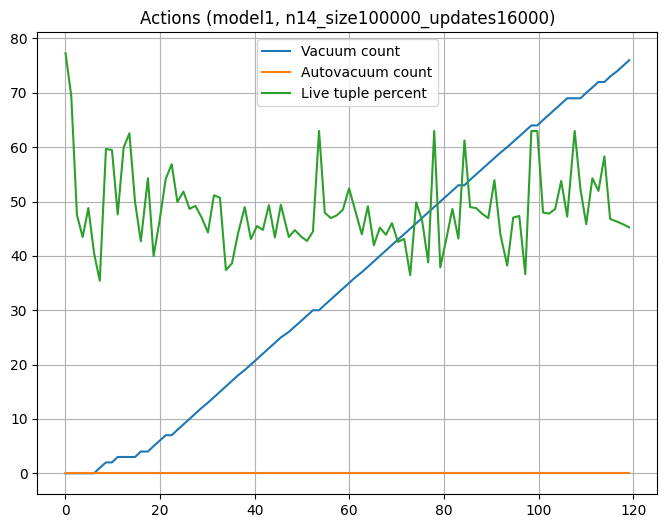

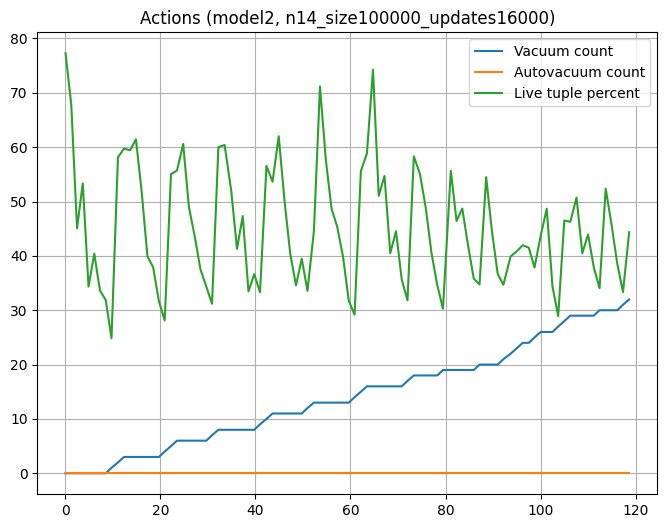

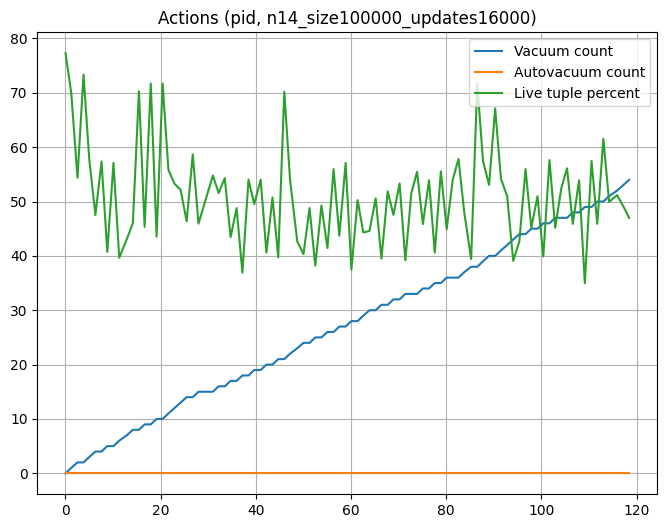

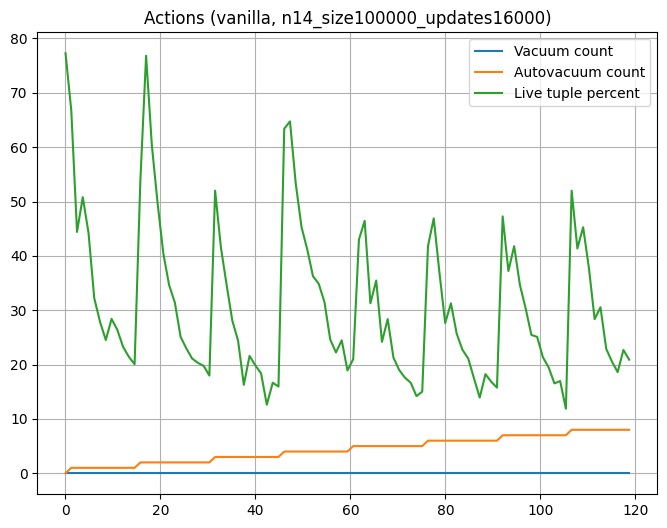

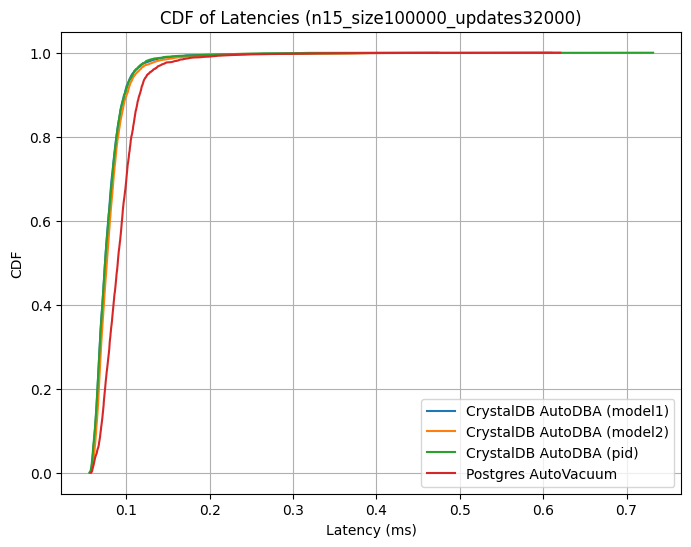

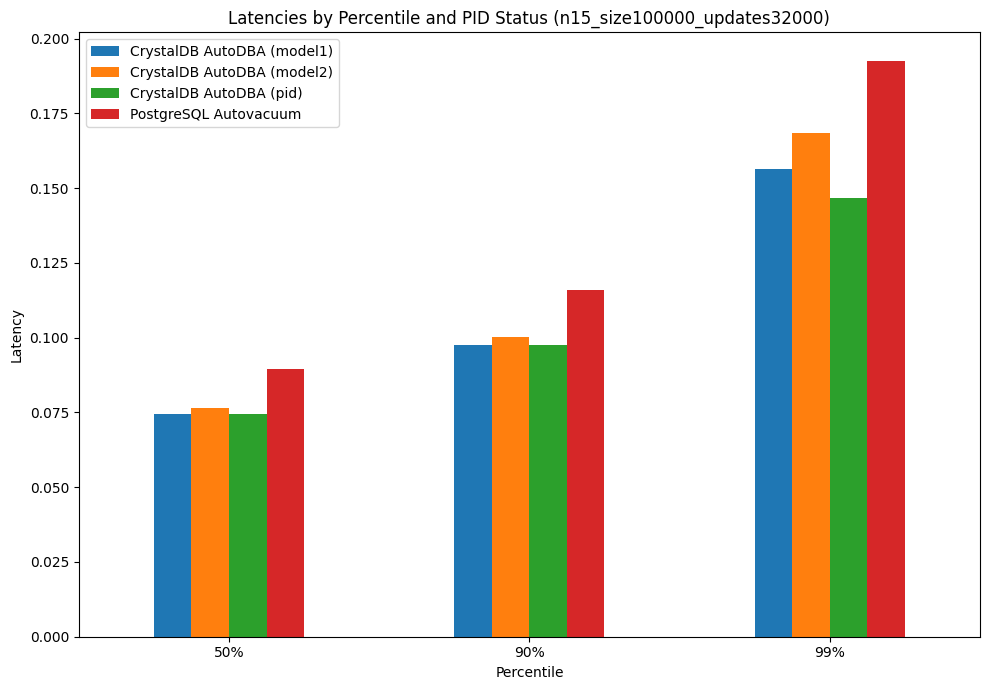

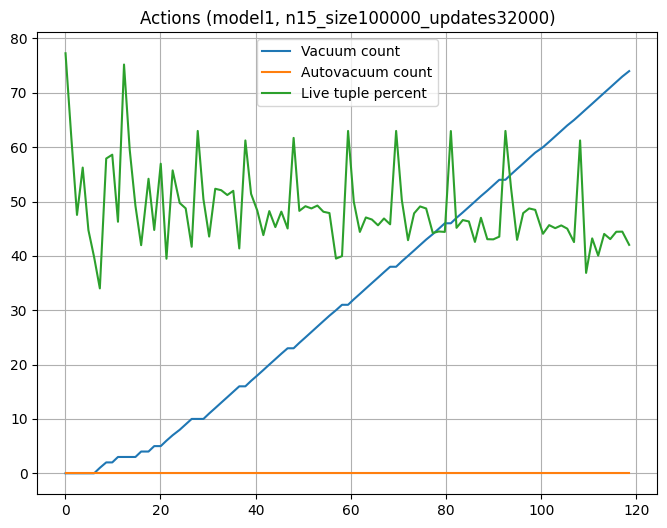

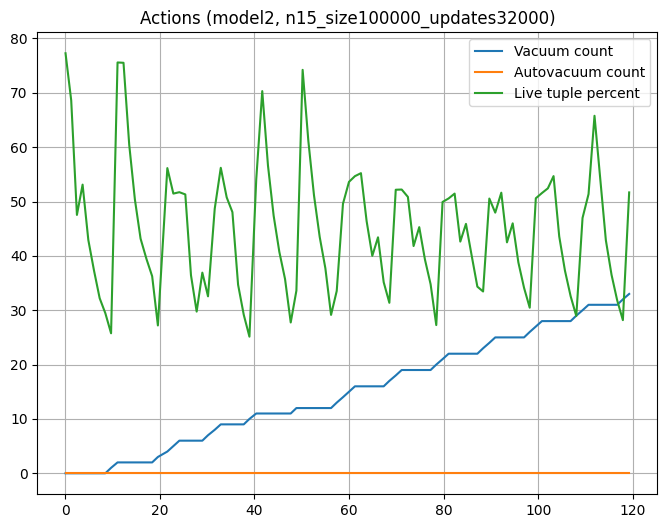

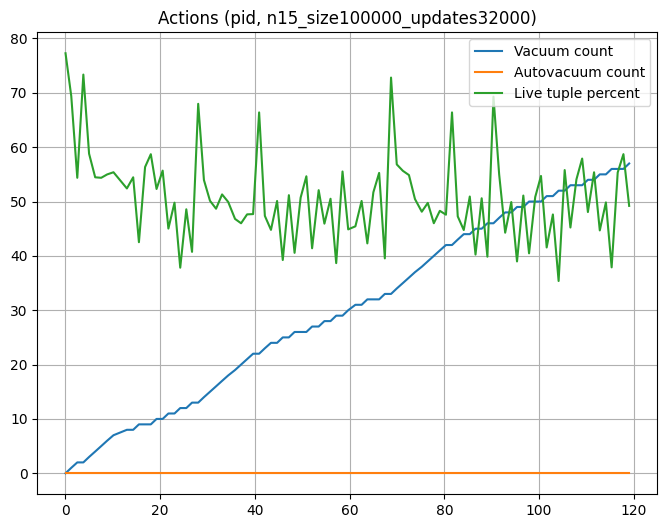

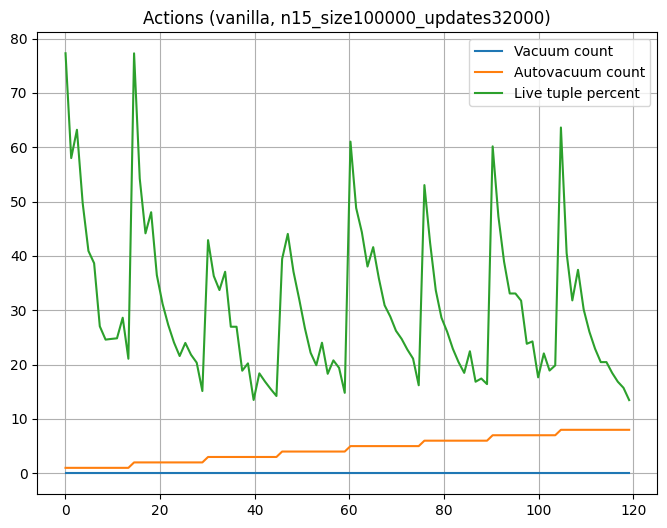

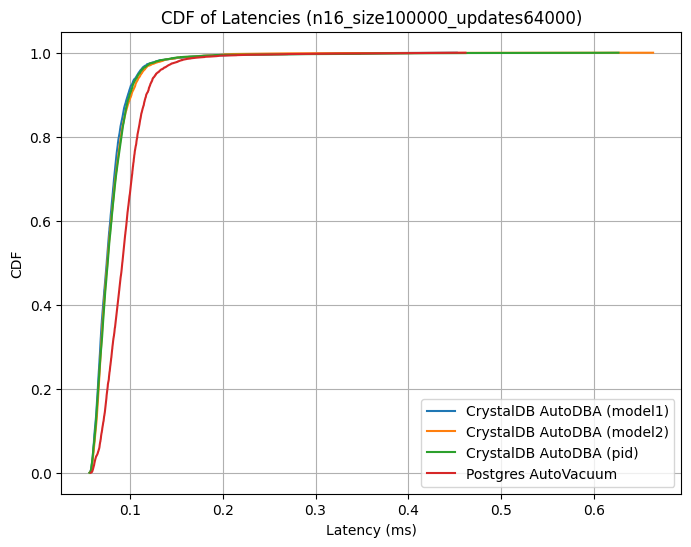

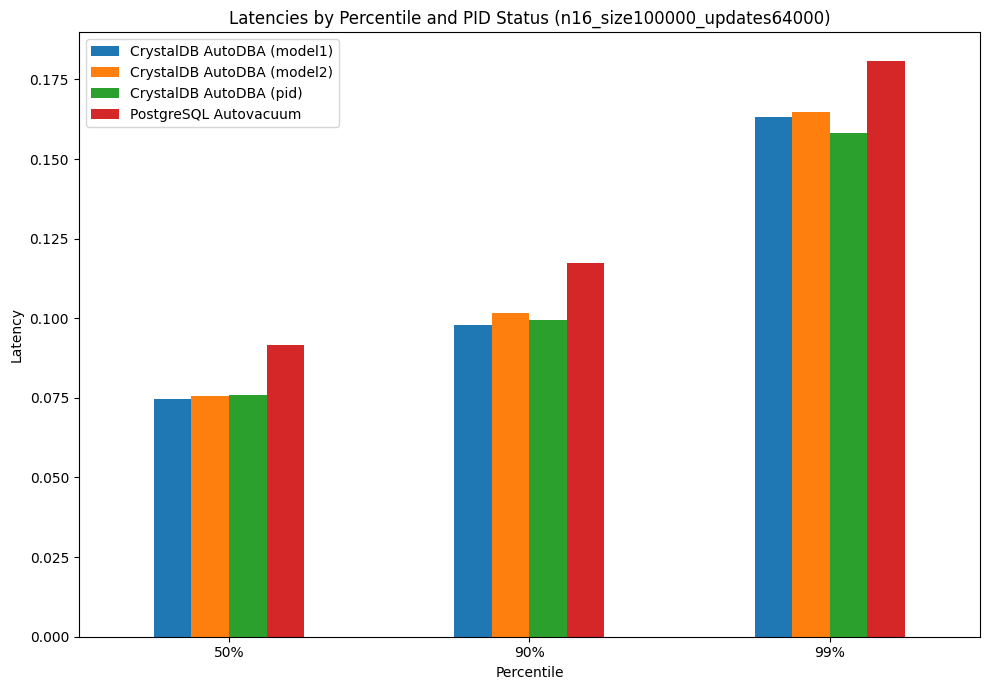

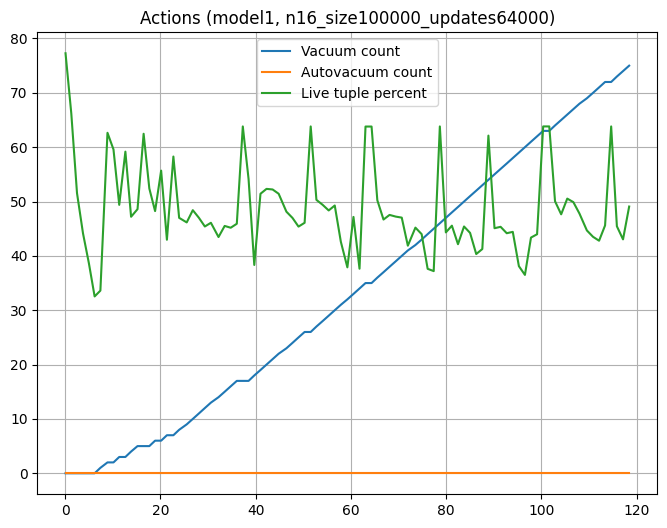

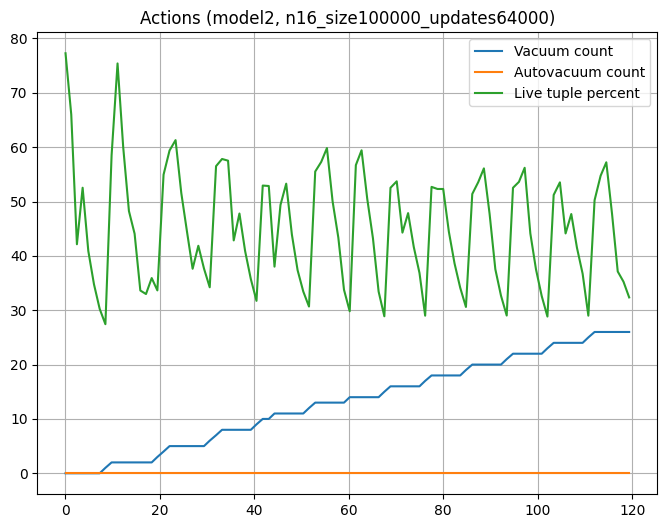

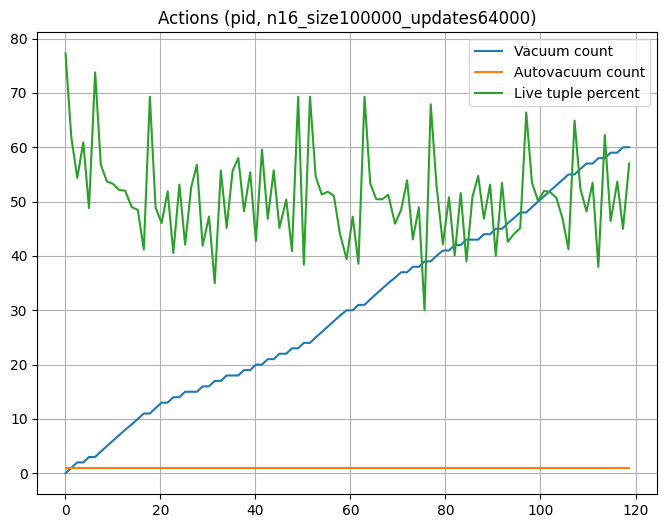

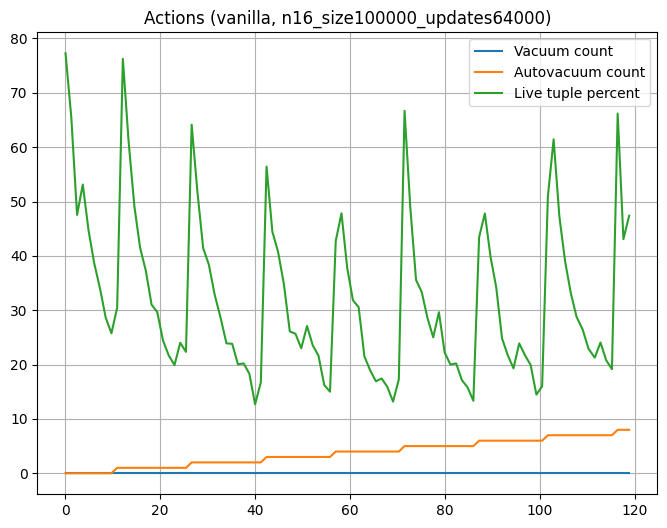

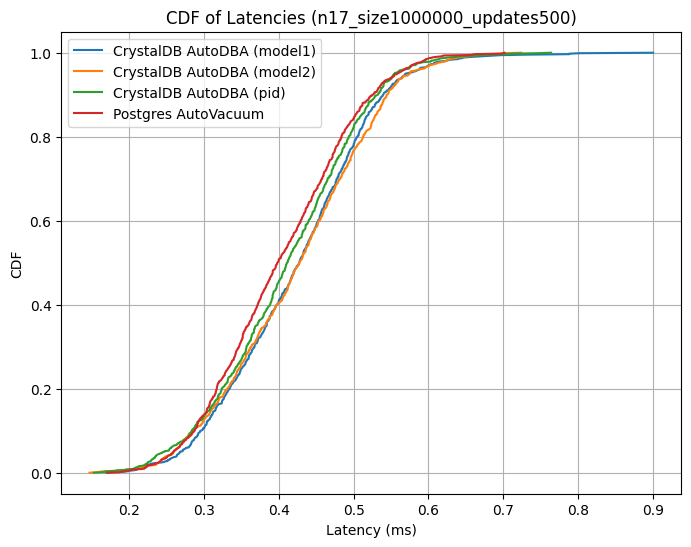

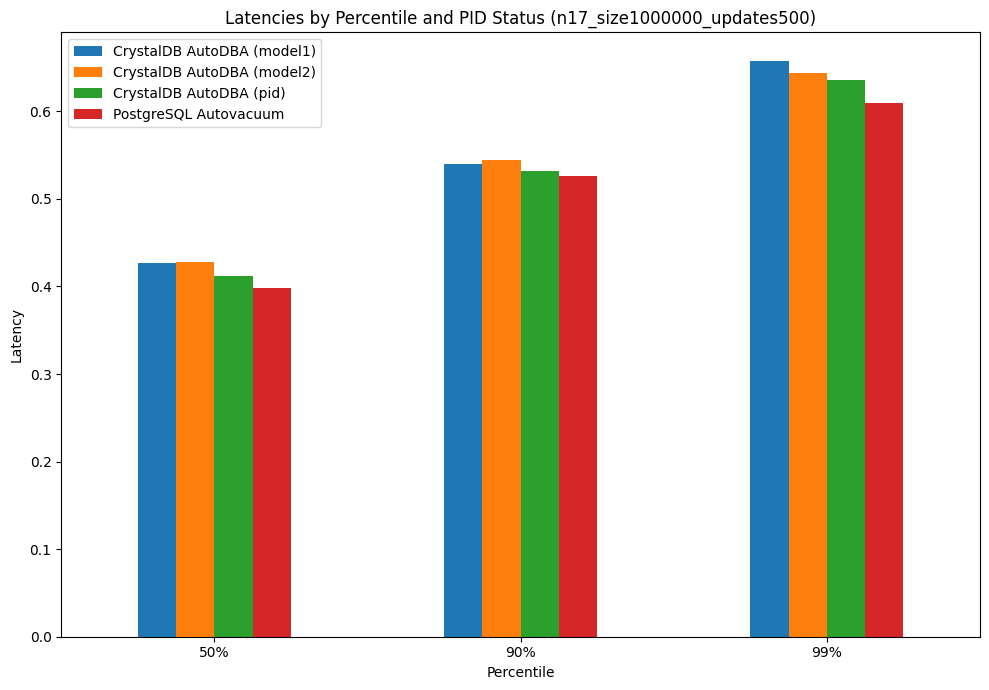

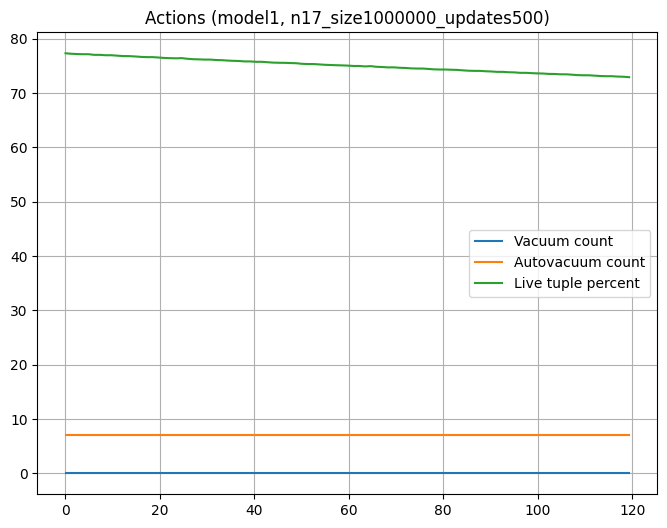

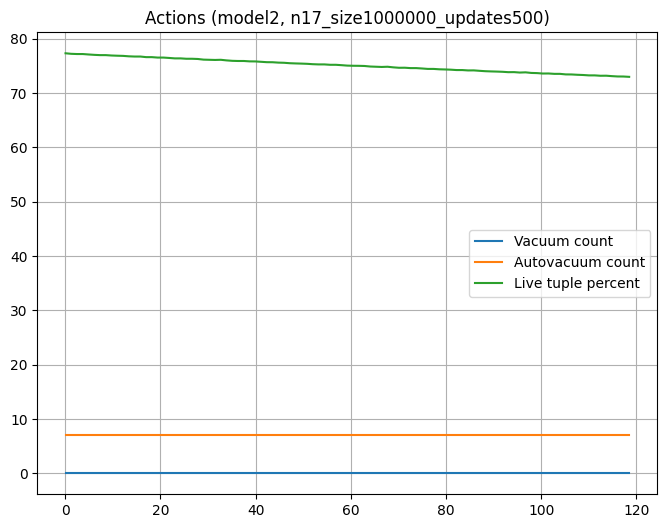

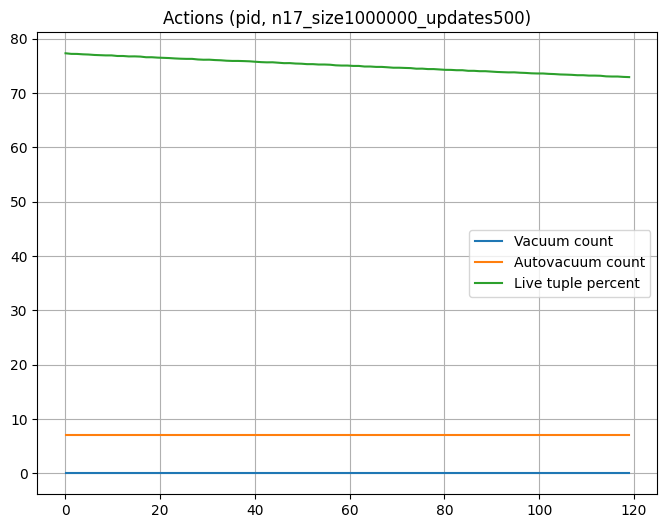

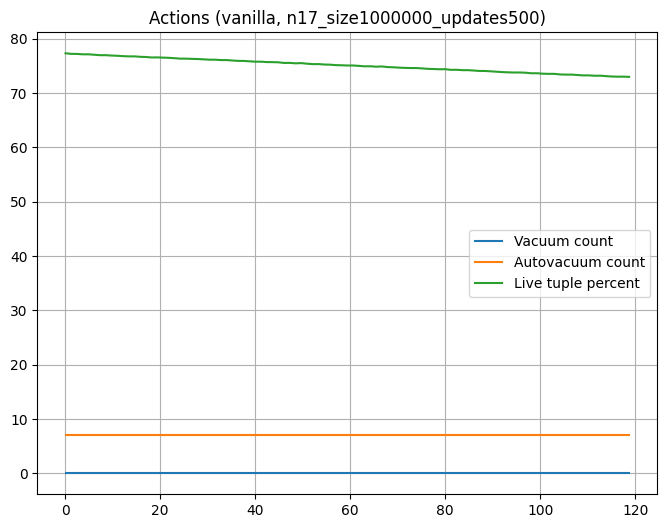

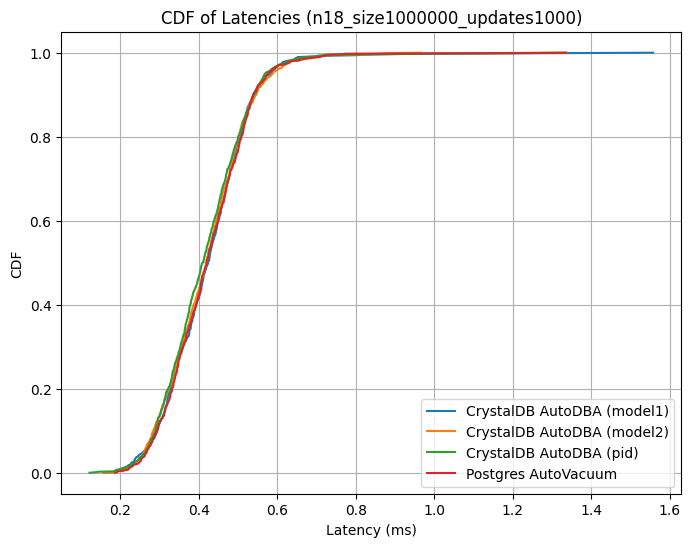

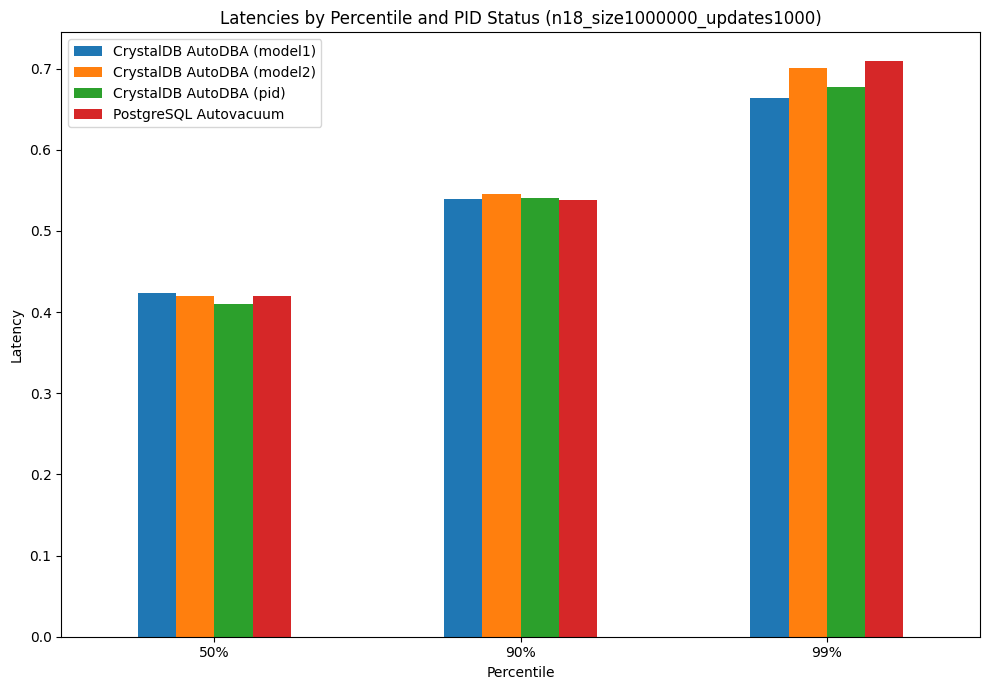

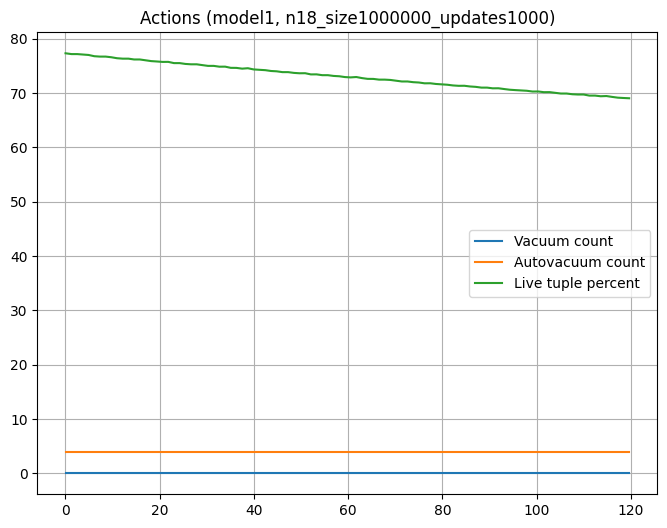

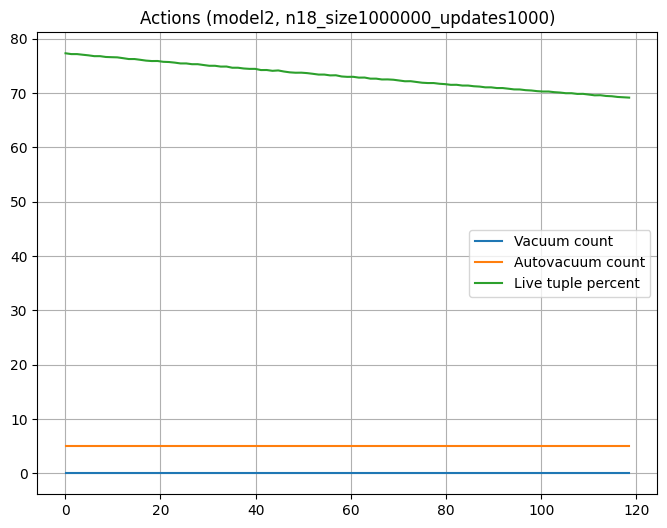

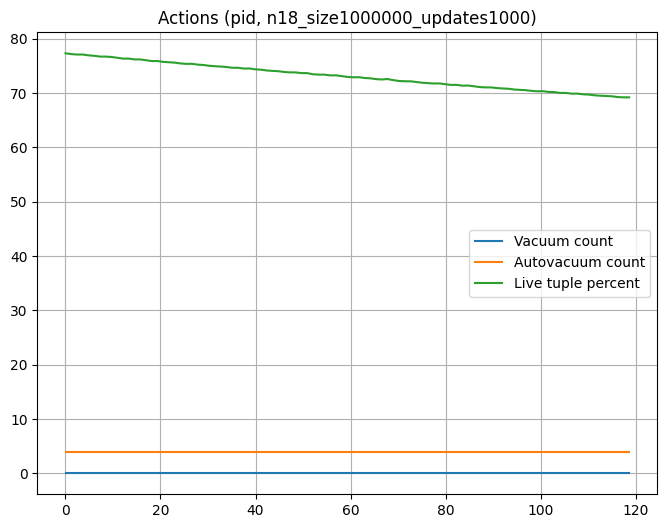

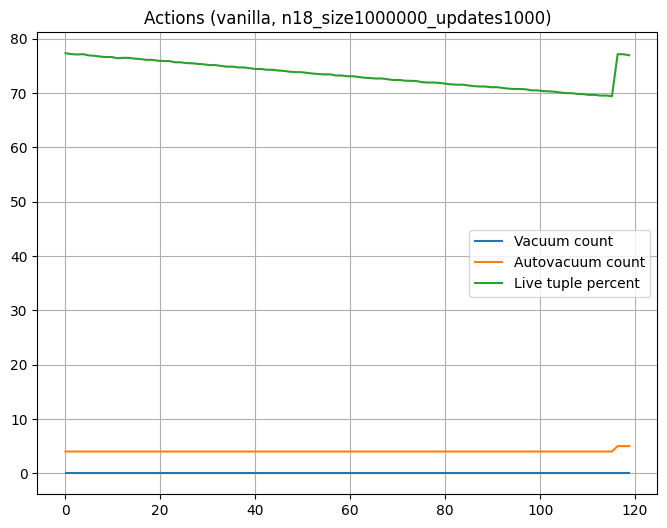

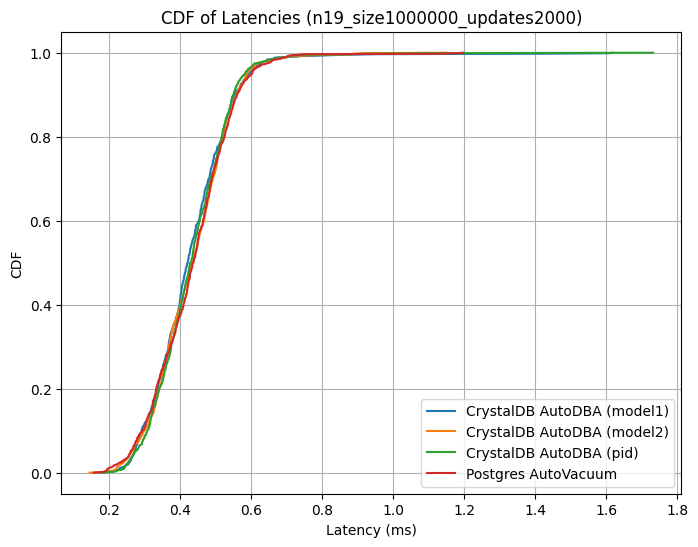

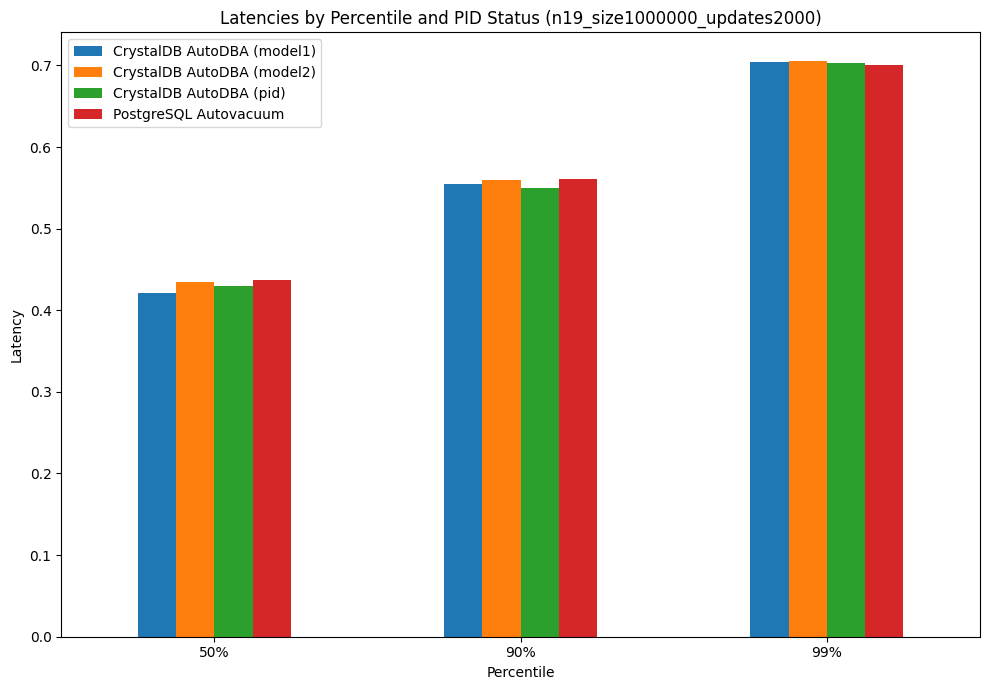

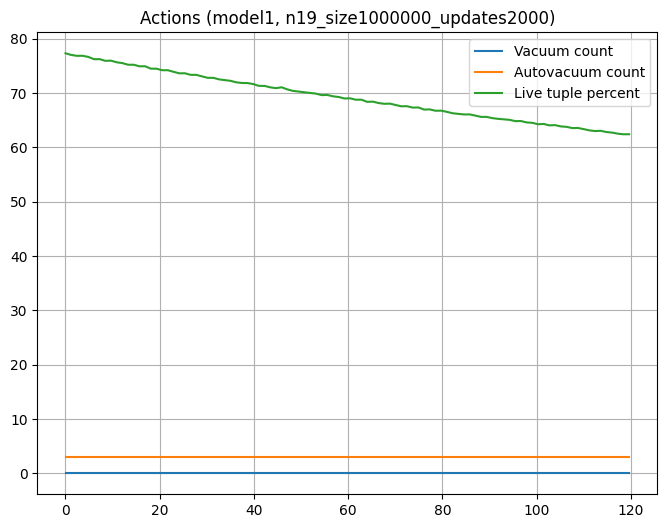

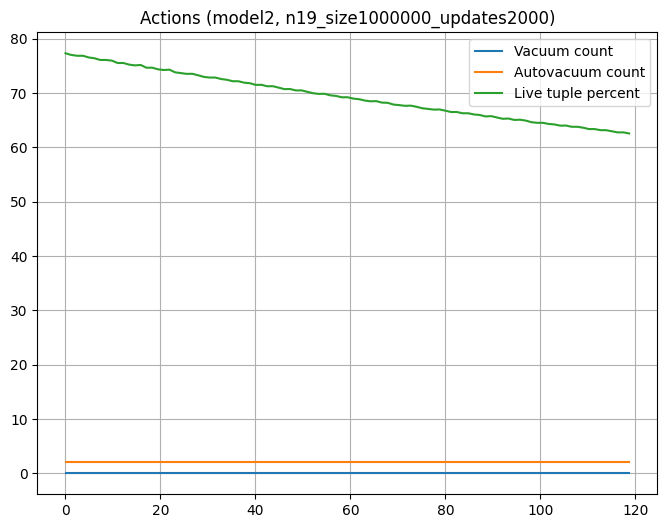

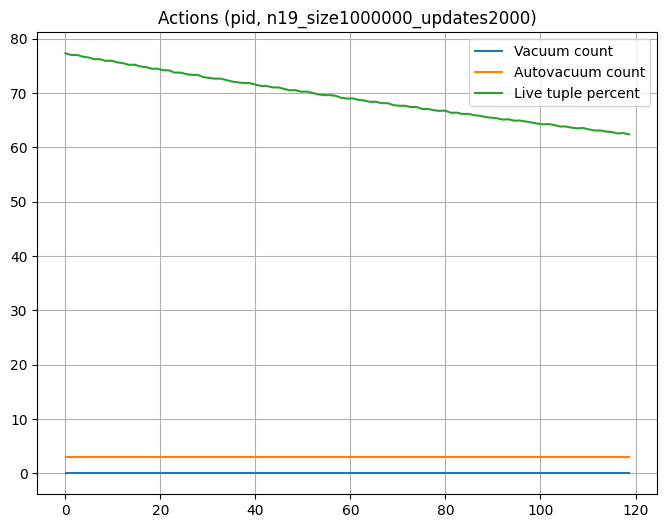

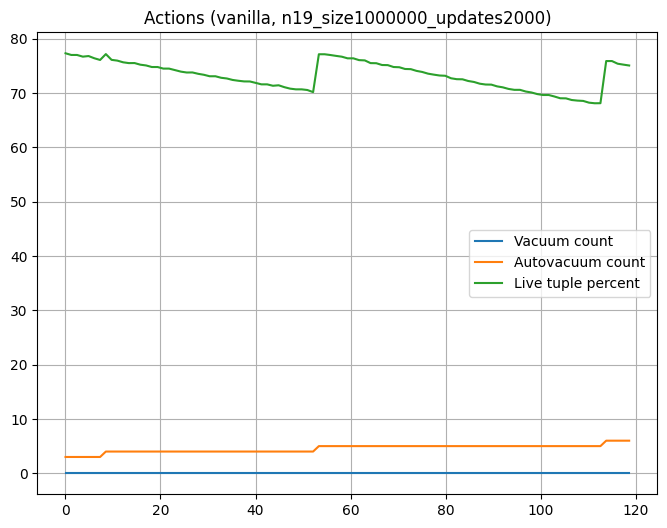

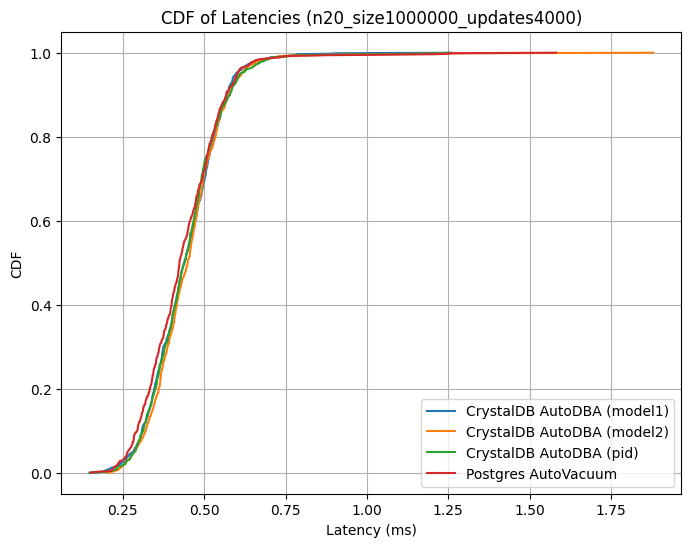

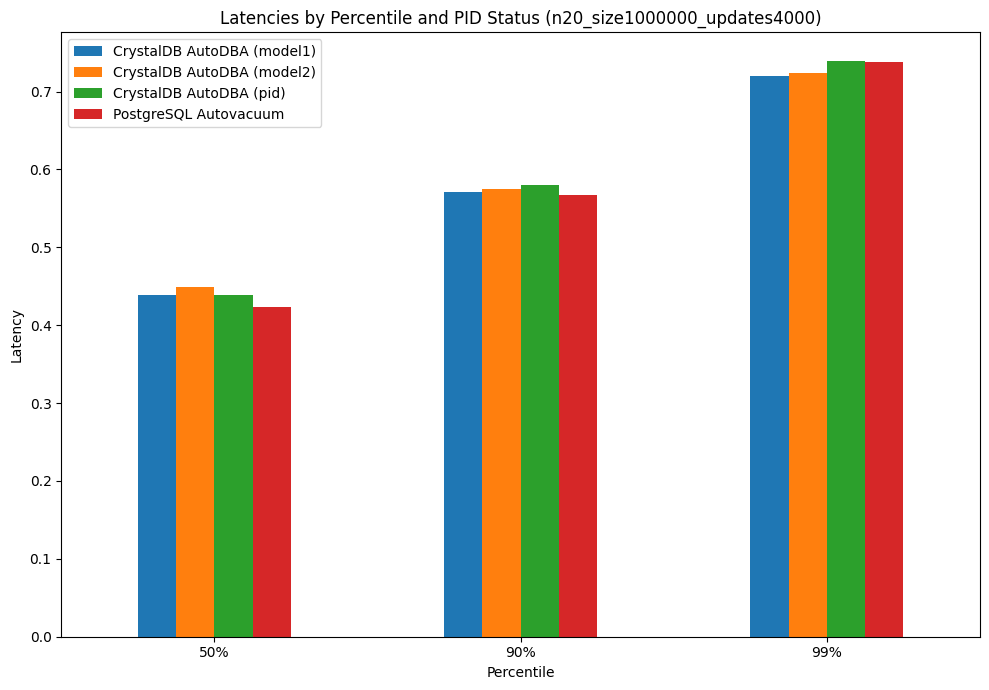

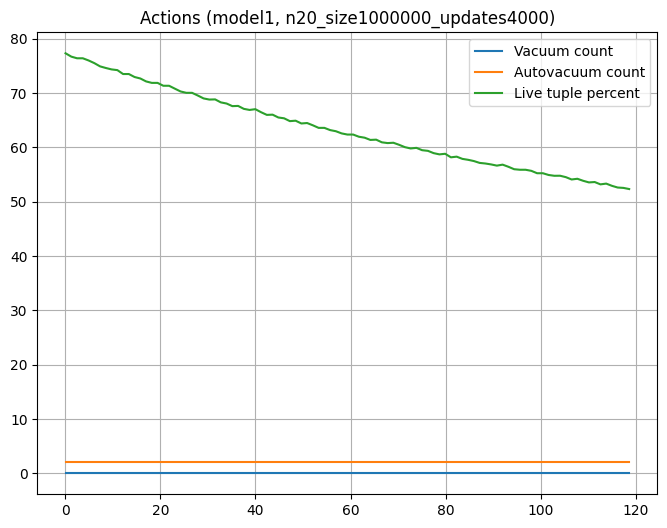

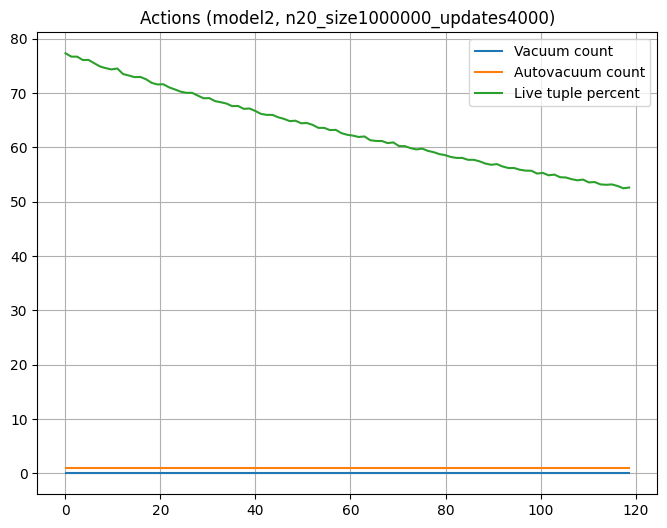

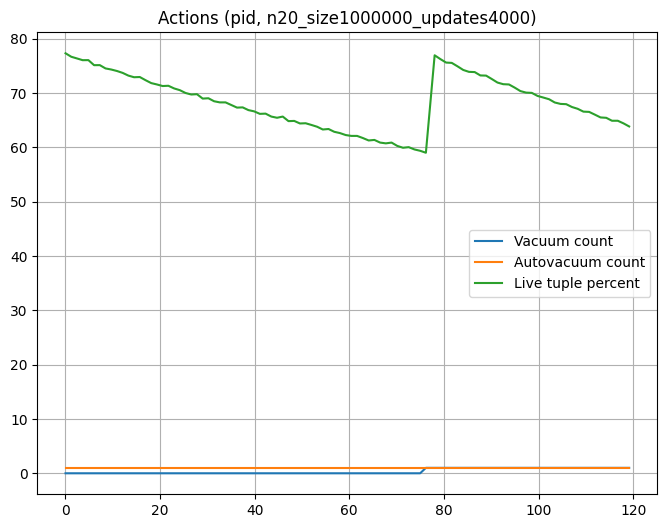

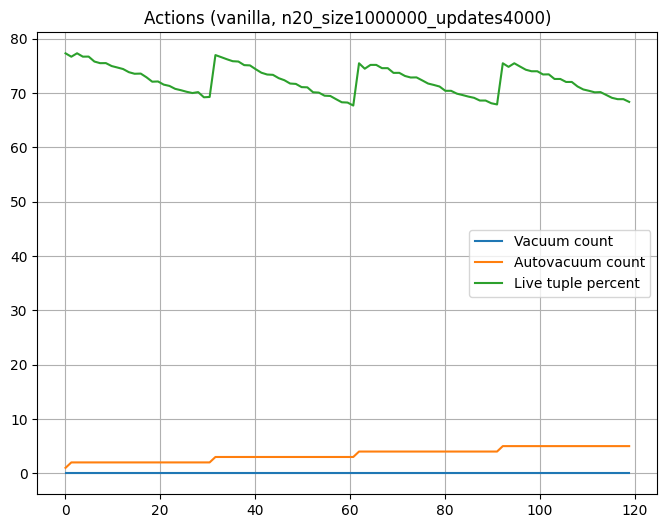

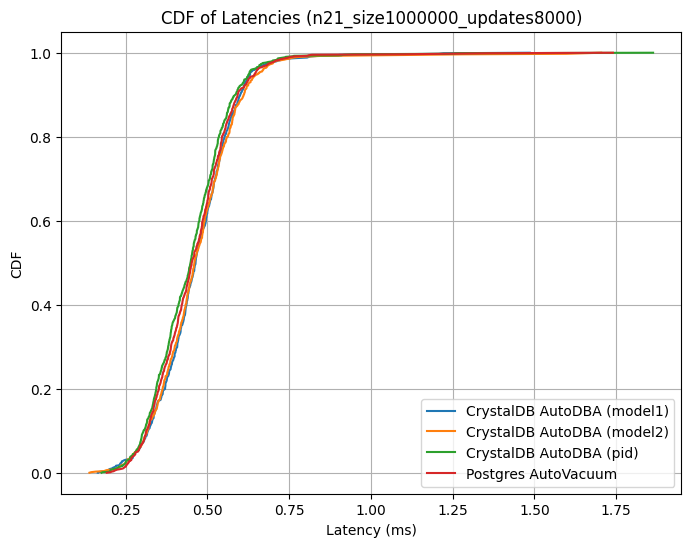

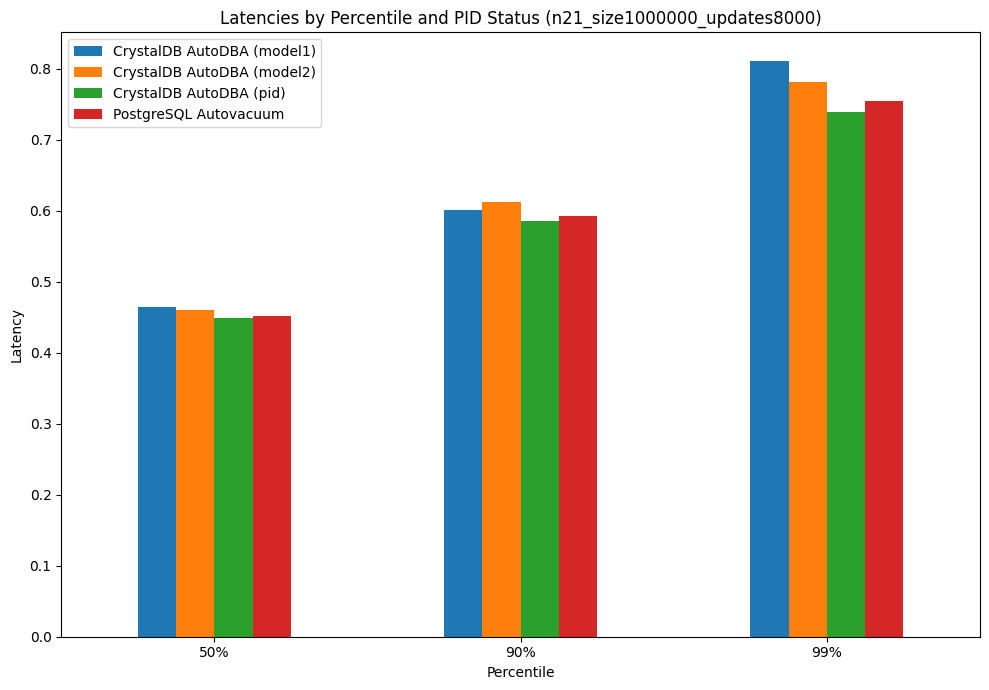

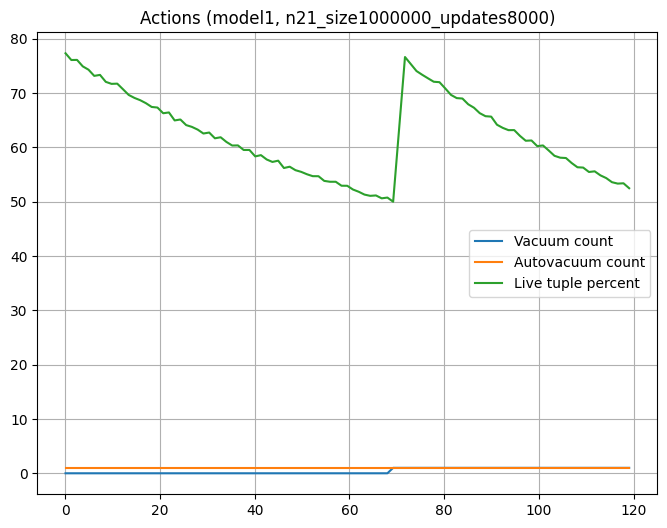

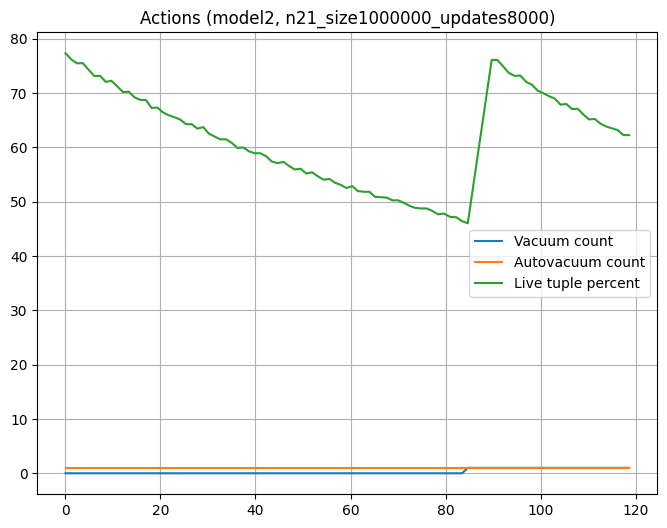

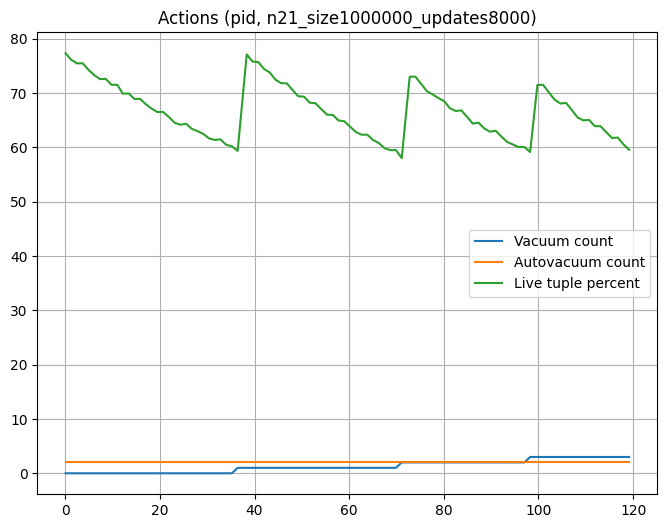

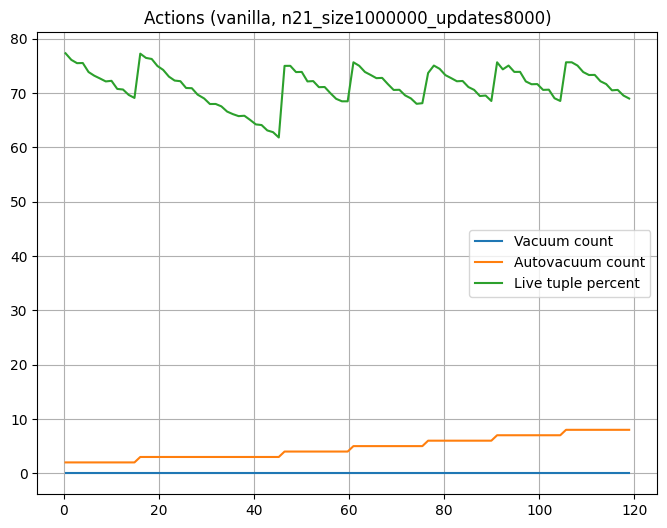

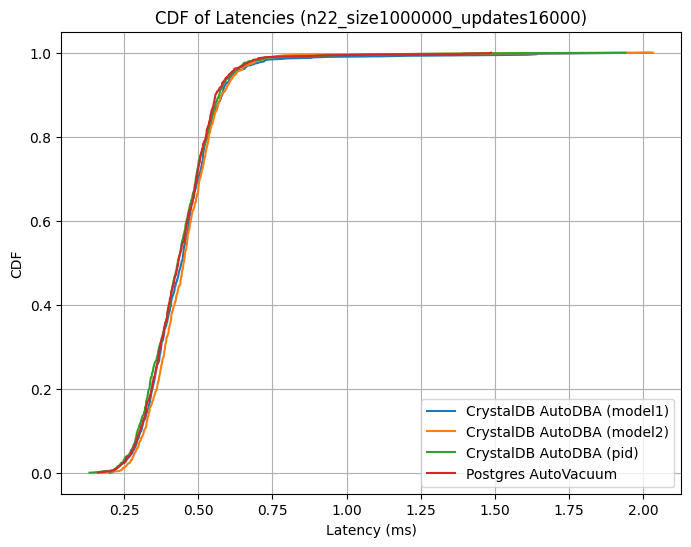

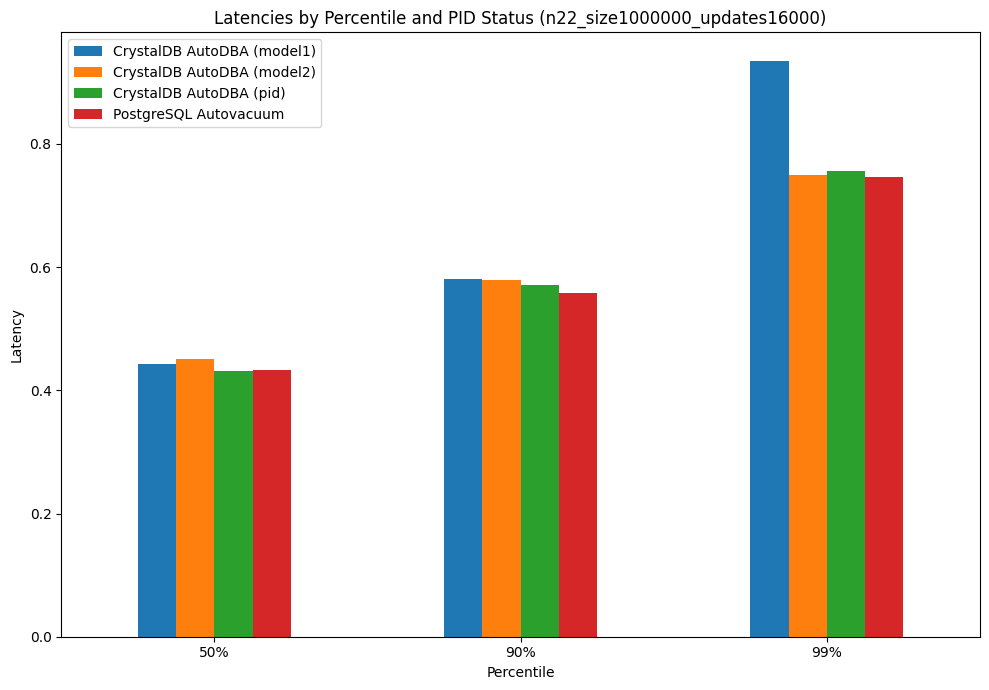

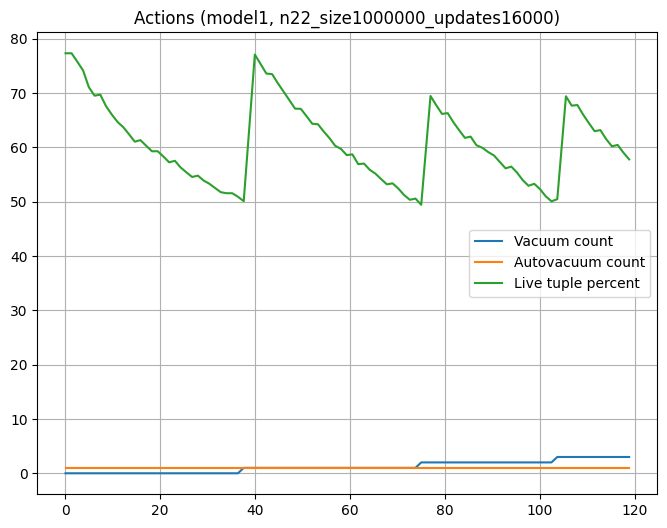

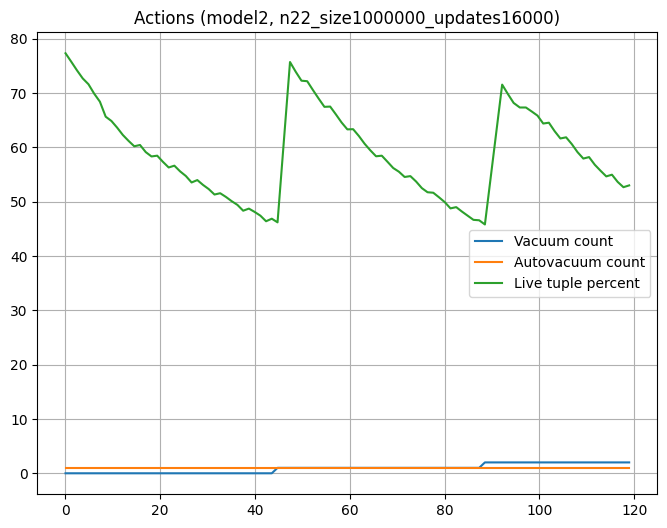

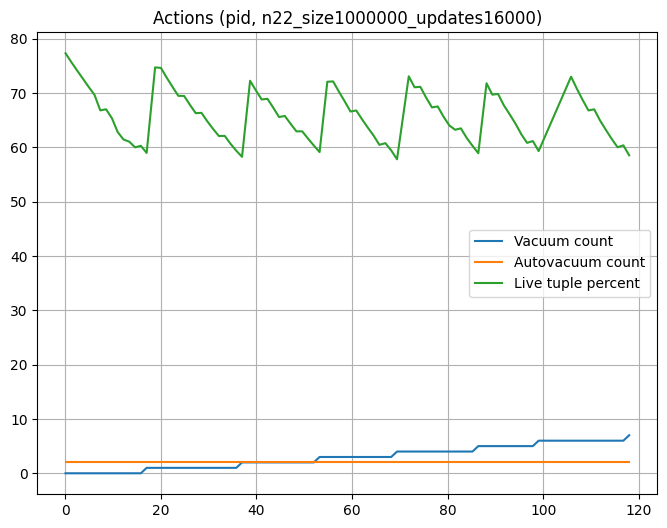

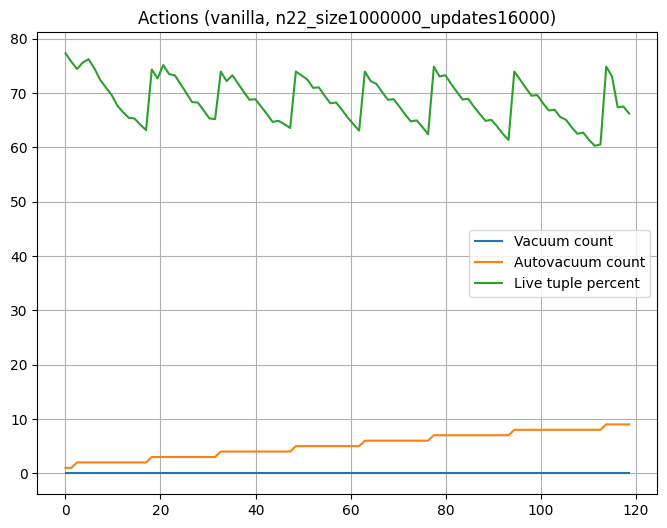

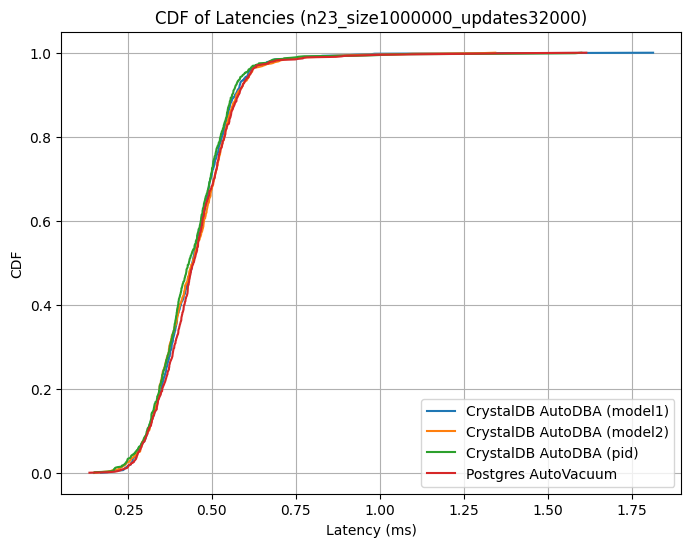

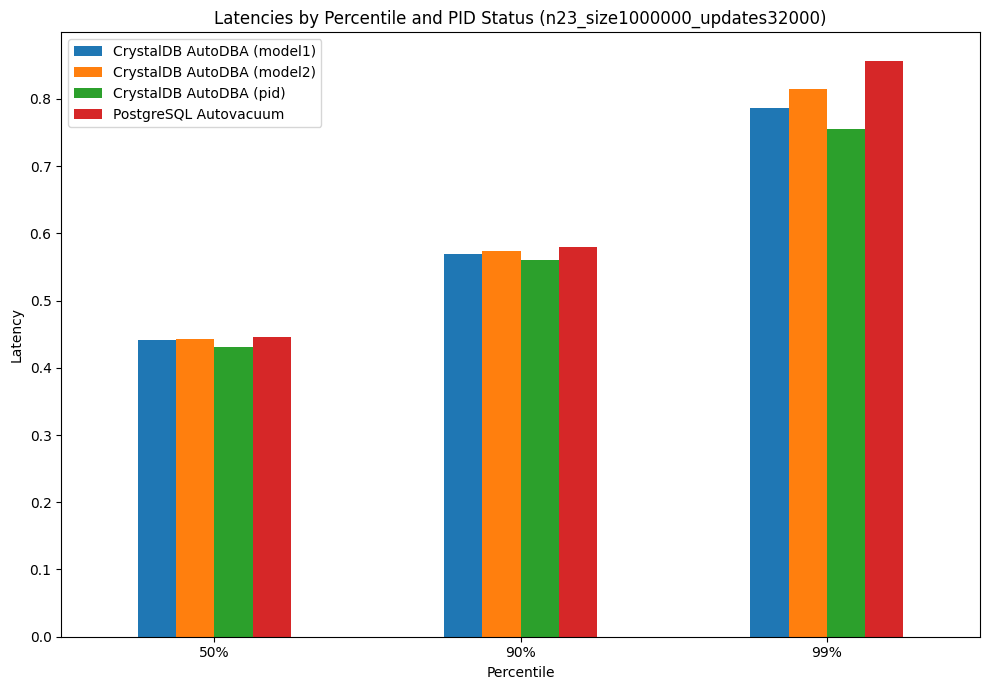

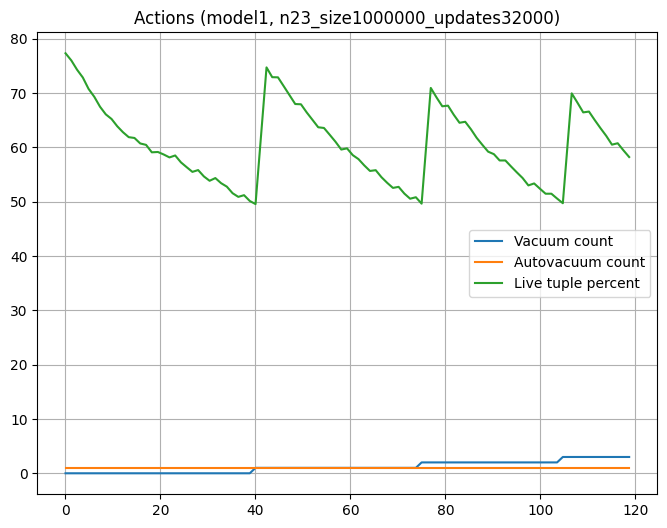

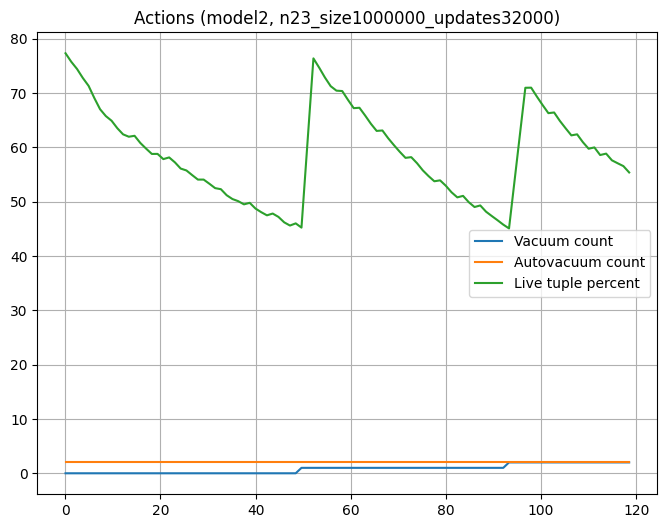

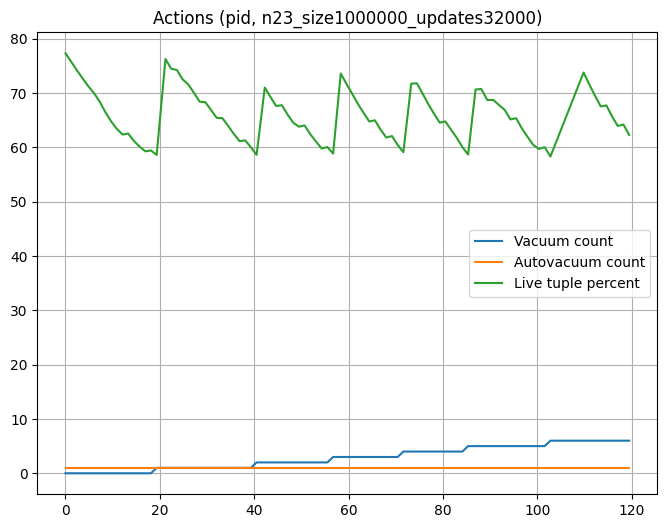

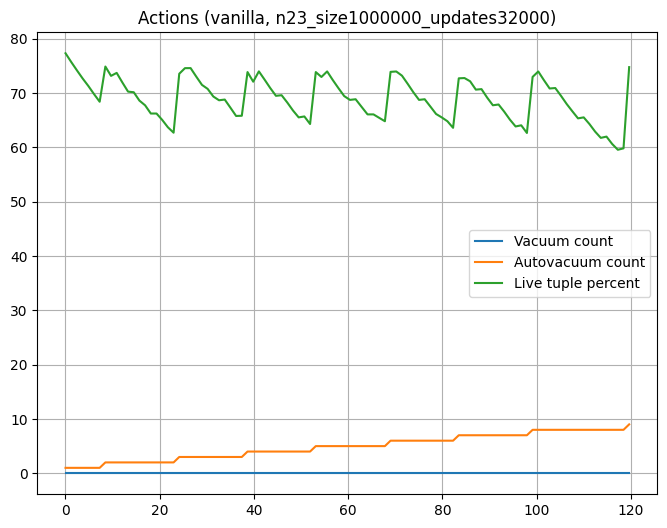

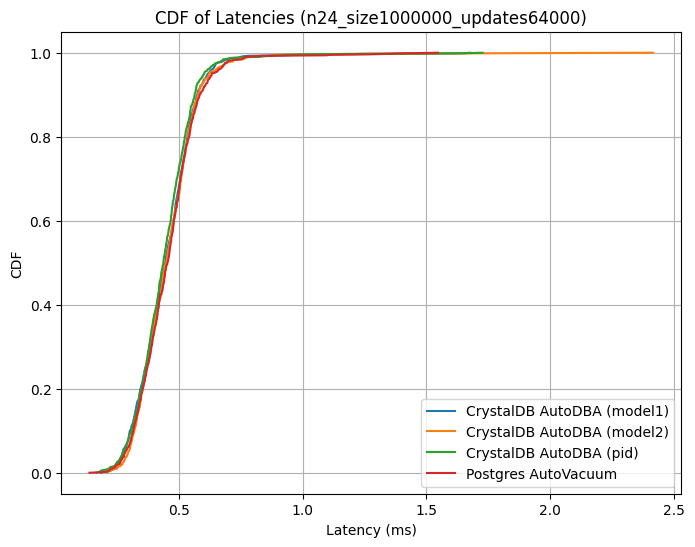

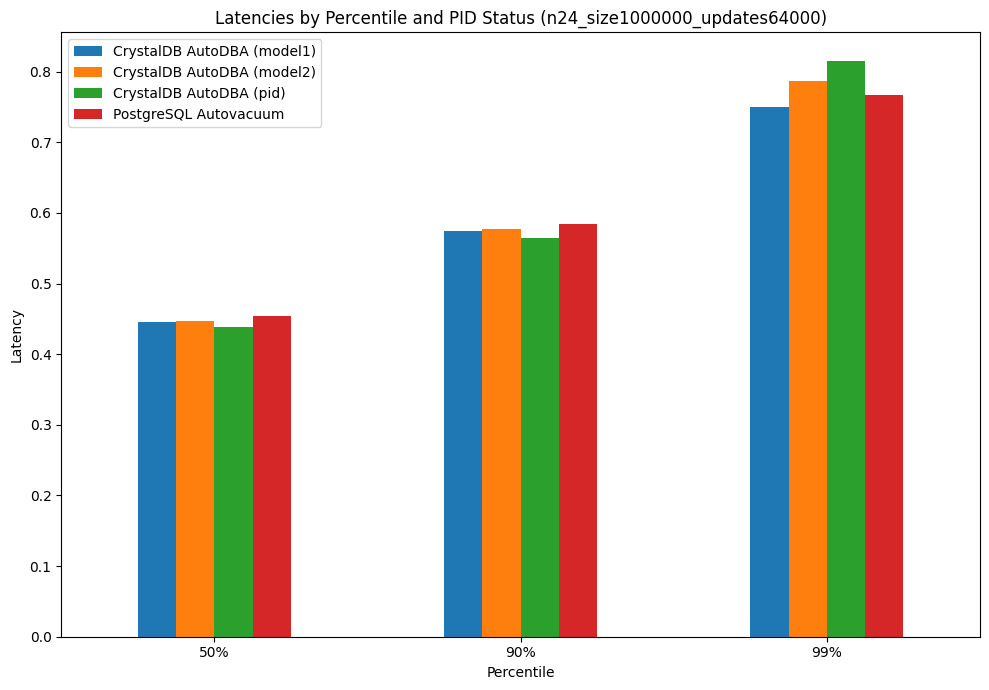

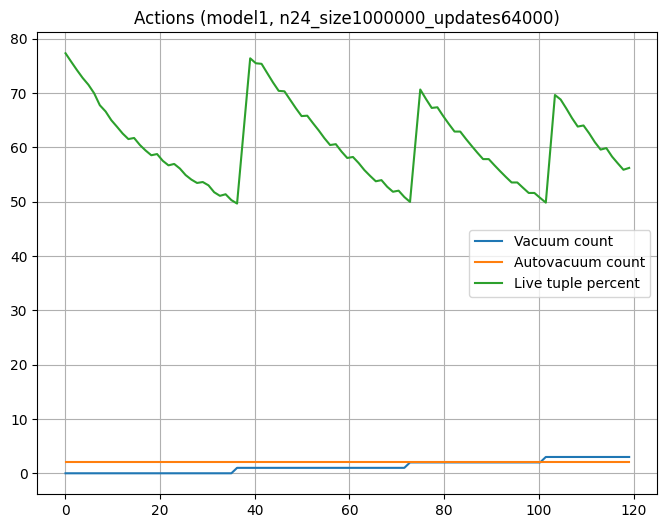

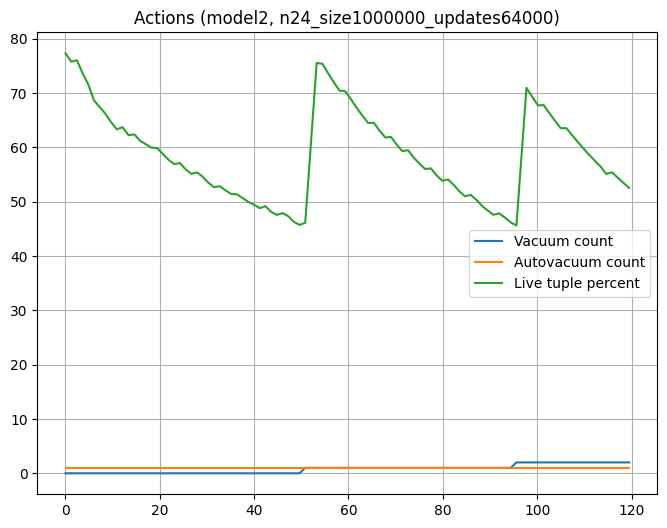

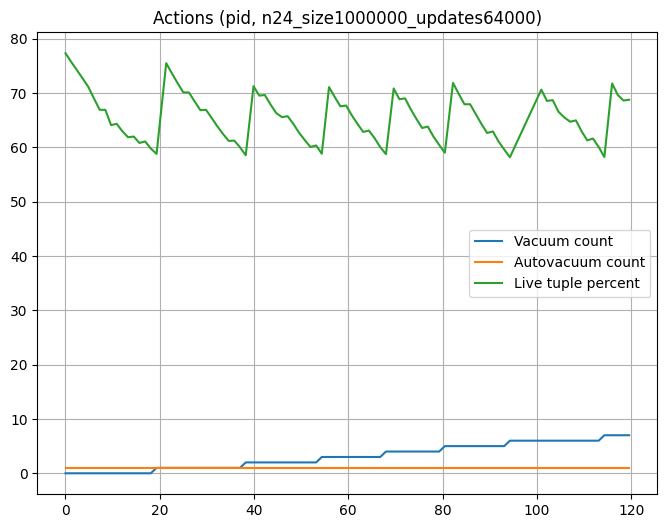

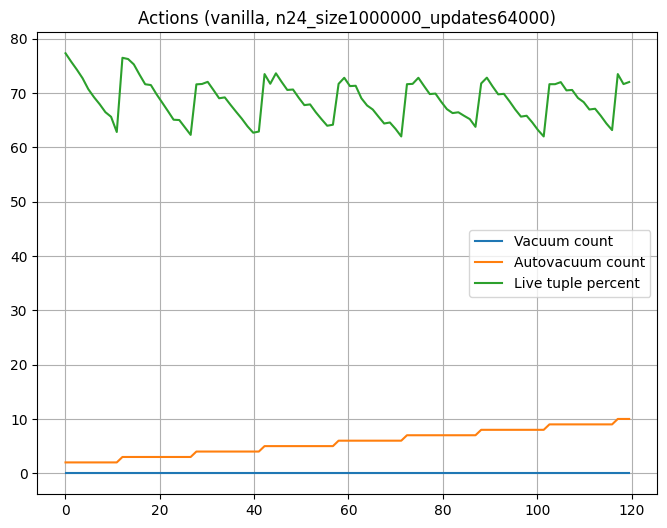

In [2]:
# Load and compute CDFs
global base_dir
print("Input directory with results:")
base_dir = input()

id = 0
for initial_size in [10000, 100000, 1000000]:
    for update_speed in [500, 1000, 2000, 4000, 8000, 16000, 32000, 64000]:
        id += 1
        experiment_id = "n%d_size%d_updates%d" % (id, initial_size, update_speed)
        plot_graphs(experiment_id)         